<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/W1_Tutorial2_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 1 Part 2
# AlphaZero

__Instructor:__ Konrad Kording

__Content creators:__ Ari Benjamin, Richard Lange, Byron Galbraith


---
# Today's agenda

Today, we will extend what we learned last time all the way to a full AlphaZero (or at least, a tiny one that will run in a Colab).

Here's the agenda:
1. Review last tutorial
2. Introduce the idea of policy and training a policy net
3. Talk about planning, tree search, and Monte Carlo Tree Search (MCTS)
4. Get AlphaZero!

In [2]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'spatank' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()



Video available at https://youtube.com/watch?v=GmAPxuPXGhM


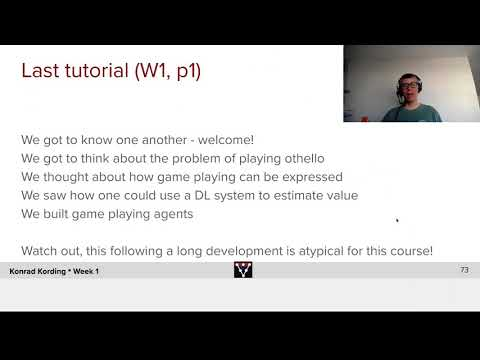

In [3]:
#@title Video: Towards AlphaZero
param_list = ['my_pennkey', 'my_pod']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="GmAPxuPXGhM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Setup


### Ensure you're running a GPU notebook.


From "Runtime" in the drop-down menu above, click "Change runtime type". Ensure that "Hardware Accelerator" says "GPU".

In [4]:
# Imports
import math
import torch
import torch.nn.functional as F
from torch import nn 
from numba import cuda, float32, int32
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import IPython
from IPython.display import IFrame
from google.colab import output
from tqdm.notebook import tqdm
from typing import List
import time

In [5]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

## Review and Recreate
To start, we've copied over much of the code from last time (`OthelloGame`, `EpsilonGreedyAgent`, `ai_vs_ai`, etc). Take a moment to make sure everything here looks familiar.

In [6]:
#@markdown Recreate OthelloGame and InteractiveOthelloGame

# Environment config so that numba knows where to find CUDA libraries
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

# 1st dimension is row, 2nd is col. Top-left corner of board is (0,0). 8 vector
# directions out from each point are:
RAYS = np.array([[0, 1],   # east
                 [0, -1],  # west
                 [1, 0],   # south
                 [-1, 0],  # north
                 [1, 1],   # southeast
                 [1, -1],  # southwest
                 [-1, 1],  # northeast
                 [-1, -1]],# northwest
                dtype=np.int32)

# ======================================
# === BEGIN CUDA-ACCELERATED HELPERS ===
# ======================================

def torch2cuda(arr:torch.Tensor) -> cuda.cudadrv.devicearray.DeviceNDArray:
    return cuda.as_cuda_array(arr)

def cuda2torch(arr:cuda.cudadrv.devicearray.DeviceNDArray) -> torch.Tensor:
    return torch.as_tensor(arr, device='cuda')

@cuda.jit(device=True)
def cuda_cast_rays(board, y0, x0, ray, player):
    """Helper CUDA kernel that searches out from row, column coordinate (y0,x0)
    in the direction specified by "ray". Returns True iff there is an unbroken
    line of opponent stones along the ray starting at (y0,x0), ending with a
    stone belonging to "player".
    
    The device=True decorator means that this may only be called from other CUDA
    kernels (see below).
    """
    n = board.shape[1]
    opponent = 3 - player
    y, x = y0+ray[0], x0+ray[1]

    # The ray must begin with an opponent stone 1 space away
    if x < 0 or y < 0 or x >= n or y >= n or board[y, x] != opponent:
        return False
    
    # Keep looking until edge of the board or we find an open space or we find
    # a player-owned stone
    y, x = y+ray[0], x+ray[1]
    while x >= 0 and y >= 0 and x < n and y < n:
        # Ray terminates on an open space. Not a valid move.
        if board[y, x] == 0:
            return False
        
        # Ray terminates on player. This is valid!
        if board[y, x] == player:    
            return True
        
        y, x = y+ray[0], x+ray[1]
        
    # Reached end of the board. Not a valid move.
    return False

@cuda.jit
def cuda_get_valid_actions(boards, player, valid_actions):
    """Helper CUDA kernel that calls cuda_cast_rays to find all legal moves
    in parallel across many boards and positions. Results are written into the
    array "valid_actions" which must be the same shape as "boards".

    Decorating with @cuda.jit means we can call it from python by passing cuda
    device array objects for "board" and "valid_actions".

    CUDA is structured by 'blocks' and 'threads'. Each block contains multiple
    threads. It is the caller's job to say how many of each and their effective
    size. For instance, cuda_get_valid_actions[4, (8,8)](...) is the syntax for
    "4 blocks, each of which has 8 'x' and 8 'y' threads".

    We use a separate block per board, and each thread evaluates a single board
    coordinate.
    """
    # From numba documentation: const.array_like copies the given array into
    # constant GPU memory *at compile time*. This means the copy only happens
    # the first time this function is called.
    rays = cuda.const.array_like(RAYS)

    # We access boards through the 1d block index (boardIdx.x) and positions
    # within the board through the thread index x and y.
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    
    # If a space is occupied, it's an illegal move and we're done. Store a zero
    # at coordinate (ty, tx) on board bx.
    if boards[bx, ty, tx] != 0:
        valid_actions[bx, ty, tx] = 0
        return

    # Try out all 8 ray directions. If any one is a hit, set return value to 1
    # and break.
    for i in range(8):
        hit = cuda_cast_rays(boards[bx], ty, tx, rays[i], player)
        if hit:
            valid_actions[bx, ty, tx] = 1
            return
    
    # We tried all of the rays and none were legal capturing moves.
    valid_actions[bx, ty, tx] = 0

@cuda.jit
def cuda_step(boards, actions, player):
    """Helper CUDA kernel for playing actions across multiple boards in parallel.

    Boards must be [num_games, n, n], actions must be [num_games, 2] and player
    must be 1 or 2. Actions are (row, col) indices of the player's stone.

    WARNING: no legality checks are performed here! It is the caller's
    responsibility to ensure that all moves are legal.

    Boards are indexed by block x and the 8 ray directions by thread x

    If either of actions[b,:] is -1, treated as pass.
    """
    # As in cuda_get_valid_actions, this copy happens once at compile time
    rays = cuda.const.array_like(RAYS)

    # Grab thread and block index from cuda context
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x  

    # Unpack the row, col coordinate of the action
    act_y, act_x = actions[bx]

    # If -1, the player passed and there is nothing to do.
    if act_x == -1 or act_y == -1:
        return

    # Search a different ray direction on each of 8 threads. ASSUMES the move
    # is legal.
    is_hit = cuda_cast_rays(boards[bx], act_y, act_x, rays[tx], player)
    if is_hit:
        dy, dx = rays[tx]
        opponent = 3 - player
        y, x = act_y+dy, act_x+dx
        while boards[bx, y, x] == opponent:
            # Modify the board, flipping opponent to player
            boards[bx, y, x] = player
            y, x = y+dy, x+dx
    
    # Only need to do this once, so just let thread #0 handle it: update
    # the board at location of the action
    if tx == 0:
        boards[bx, act_y, act_x] = player

@torch.jit.script
def zobrist_hash(boards:torch.Tensor, player:torch.Tensor, table:torch.Tensor, out:torch.Tensor):
    n_games, n, _ = boards.size()
    flat_boards = boards.reshape(n_games, n*n)
    bit_strings = table[torch.arange(n*n), flat_boards.long()]
    # Reset output values to 0
    out.fill_(0)
    # We have to loop manually because bitwise_xor has no dimension
    # argument (see https://github.com/pytorch/pytorch/issues/35641)
    for i in range(n*n):
        torch.bitwise_xor(out, bit_strings[:,i], out=out)
    # Just add the current player - ok that this isn't random bitstrings because
    # just a single integer added per game.
    torch.add(out, player, out=out)
    return out

# ====================================
# === BEGIN OTHELLOGAME DEFINITION ===
# ====================================

class OthelloGame(object):
    PLAYER1 = 1
    PLAYER2 = 2
    ACTIVE = 0
    OVER = 1
    PASS = (-1, -1)
    # Unicode characters for dark and light circles if printing to console.
    # By convention, player 1 is dark and 2 is light.
    GAME_SYMBOLS = ['_', '\u25cf', '\u25cb']

    def __init__(self, n_games=1, n=8):
        """Create a new batch of n_games othello games each with board size [n,n]

        The game states are managed on the GPU with the help of CUDA kernels.

        We expect all n games to update in lockstep, so that there is only one
        'current_player' shared by all of them.
        """
        self.n_games = n_games
        self.n = n
        self.boards = torch.zeros((n_games, n, n), dtype=torch.float32, device='cuda')
        # Initial positions: 4 stones in the center alternating color
        self.boards[:, [self.n//2, self.n//2-1], [self.n//2, self.n//2-1]] = OthelloGame.PLAYER2
        self.boards[:, [self.n//2, self.n//2-1], [self.n//2-1, self.n//2]] = OthelloGame.PLAYER1
        # Always start with player 1 (dark stones by convention)
        self.current_player = OthelloGame.PLAYER1
        # All games are initially active
        self.game_status = OthelloGame.ACTIVE*torch.ones(n_games, dtype=torch.int32, device='cuda')
        # If both players pass the game is over. Keep track of whether the last
        # player passed.
        self.last_player_pass = torch.zeros(n_games, dtype=torch.int32, device='cuda')

        # _valid_moves is a container for storing which moves are valid. It is
        # zero everywhere except where it is legal to play, which is 1.
        self._valid_moves = torch.zeros_like(self.boards)

        # Create a CUDA device array copy of each GPU tensor. These share GPU
        # memory with torch tensors so any changes made in CUDA kernels are seen
        # by torch.
        self._cuda_boards = torch2cuda(self.boards)
        self._cuda_valid = torch2cuda(self._valid_moves)

        # Populate valid moves using CUDA-ized algorithm
        self.refresh_legal()

        # Initialize 'zobrist hash' table for get_uid() function
        self._new_zobrist_table()

    def step(self, actions:torch.Tensor):
        """Place a stone for the current player at location action=(row,col)
        separately per board. Expected size of 'actions' is [n_games, 2].

        Action coordinates of -1 treated as passing.

        Actions are ignored for all games that are not in the ACTIVE state.

        Note: no legality checking here! It is the caller's responsibility to
        ensure 'action' is legal, e.g. by checking that action is in
        game.get_available_actions().
        """
        # Ensure actions is a torch tensor and on the GPU. Ensure its shape is
        # [n_games, 2] even if the input was, say, just a (row,col) tuple.
        actions = torch.as_tensor(actions, device='cuda').view(-1, 2)

        # Ensure actions are "pass" for games that have completed. This tells
        # the cuda_step kernel to ignore these games.
        actions[self.game_status == OthelloGame.OVER, :] = -1

        # Update board state with call to CUDA kernel cuda_step.
        cuda_step[self.n_games, RAYS.shape[0]](self._cuda_boards, torch2cuda(actions), self.current_player)

        # Advance to the next player (2->1 and 1->2).
        self.current_player = 3-self.current_player

        # Count passes - any games with 2 passes in a row is flagged as being over.
        is_pass = torch.any(actions == -1, dim=1)
        self.last_player_pass[~is_pass] = 0
        self.last_player_pass[is_pass] += 1

        # Flag games that have finished
        is_game_over = self.last_player_pass >= 2
        self.game_status[is_game_over] = OthelloGame.OVER

        # Refresh legal moves for the next turn
        self.refresh_legal()
    
    def refresh_legal(self):
        # Look for valid moves in the updated boards for the new player
        cuda_get_valid_actions[self.n_games, (self.n, self.n)](self._cuda_boards, self.current_player, self._cuda_valid)

    def copy_state(self, idx=None):
        # Grab the minimal amount of state info to be able to return the board
        # to its current configuration later with a call to paste_state.
        # NOTE: this copy is single-use only; once it is pasted, it will be
        # modified in-place!
        return {"boards": self.boards.clone(),
                "game_status": self.game_status.clone(),
                "last_player_pass": self.last_player_pass.clone(),
                "current_player": self.current_player}

    def paste_state(self, state):
        self.__dict__.update(state)
        self._cuda_boards = torch2cuda(self.boards)
        self._cuda_valid = torch2cuda(self._valid_moves)
        cuda_get_valid_actions[self.n_games, (self.n, self.n)](self._cuda_boards, self.current_player, self._cuda_valid)

    def render(self, mode='human'):
        boards = self.boards.cpu()
        acts = self.get_available_actions()
        for g in range(self.n_games):
            if mode == 'text':
                print("="*(self.n-1) + (f"{OthelloGame.GAME_SYMBOLS[self.current_player]}")*2 + "="*(self.n-1))
                for row in boards[g]:
                    print(" ".join(OthelloGame.GAME_SYMBOLS[v] for v in row))
                print("="*(self.n*2))
            else:
                # Plot with matplotlib patches. Player 1 is dark and 2 is light.
                fig, ax = plt.subplots(figsize=(6,6))
                ax.set_aspect('equal')
                rect = patches.Rectangle((0,0),self.n,self.n,linewidth=1,edgecolor='k',facecolor='g')
                ax.add_patch(rect)
                ax.set_xlim(0,self.n)
                ax.set_ylim(0,self.n)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.tick_params(length=0)
                ax.grid(which='major', zorder=0, c='k')
                for i in range(self.n):
                    for j in range(self.n):
                        if boards[g,i,j]>0:
                            # Draw stones
                            c = (0,0,0,1) if boards[g,i,j]==OthelloGame.PLAYER1 else (1,1,1,1)
                            circ = patches.Circle((j+.525,self.n-1-i+.5), .4, 
                                                facecolor=c, linewidth=1,edgecolor='k')
                            ax.add_patch(circ)
                        elif (i,j) in acts[g]:
                            # Draw transluscent stones on legal move positions
                            c = (0,0,0,0.25) if self.current_player==OthelloGame.PLAYER1 else (1,1,1,0.25)
                            circ = patches.Circle((j+.525,self.n-1-i+.5), .4, facecolor=c, linewidth=0)
                            ax.add_patch(circ)
                plt.show()

    def get_available_actions(self):
        """Get a list of all legal actions for the current player (passing not included).
        
        Note: assumes self._valid_moves is up to date!
        """
        acts = [None]*self.n_games
        for g in range(self.n_games):
            i, j = torch.where(self._valid_moves[g] == 1)
            acts[g] = list(zip(i.cpu().numpy(), j.cpu().numpy()))
        return acts

    def are_games_over(self):
        return torch.all(self.game_status == OthelloGame.OVER).item()

    def score_games(self):
        """Compute [n_games, 2] tuple containing "scores" for player 1 and 2 in
        each column. Assumes game is over.

        scores[:,0] is +1 if player 1 won, 0 for draw, or -1 for loss
        scores[:,1] is the same from player 2's perspective
        """
        flat_boards = self.boards.view(self.n_games, -1)
        n_dark = torch.sum(flat_boards == OthelloGame.PLAYER1, dim=1)
        n_lite = torch.sum(flat_boards == OthelloGame.PLAYER2, dim=1)
        scores = torch.zeros_like(n_dark)
        scores[n_dark > n_lite] = +1
        scores[n_dark < n_lite] = -1
        return torch.stack([scores,-scores], dim=1)
    
    def get_uid(self, player=None, out=None):
        """Return highly-probably-unique identifier for each game. Output is a
        tensor of [n_games] int64 values.

        Algorithm is Zobrist hashing.
        """
        if player is None:
            player = self.current_player * torch.ones(self.n_games, dtype=torch.int64, device='cuda')
        elif not isinstance(player, torch.Tensor) or len(player) == 1:
            player = player * torch.ones(self.n_games, dtype=torch.int64, device='cuda')
        if out is None:
            out = torch.zeros(self.n_games, dtype=torch.int64, device='cuda')
        return zobrist_hash(self.boards, player, self._hash_board, out)

    def _new_zobrist_table(self):
        self._hash_board = torch.randint(2**63-1, size=(self.n*self.n, 3), dtype=torch.int64, device='cuda')
        # Sanity check that no 2 random strings were identical
        assert len(self._hash_board.flatten().unique()) == self.n*self.n*3

################################
#### INTERACTIVE GAME BOARD ####
################################

def temporary_info(message, clear=False):
    """Output overwritable message to the console. If clear=True, overwrite all old messages
    """
    if clear:
        output.clear(output_tags="temporary-info")
    with output.use_tags("temporary-info"):
        print(message)

class InteractiveOthelloGame(object):
    def __init__(self, game=None, player1="human", player2="human", n=8):
        if game is None:
            self.game = OthelloGame(n_games=1, n=n)
        else:
            self.game = game
            assert game.n_games == 1, "Can't handle >1 games interactively!"
        self.players = [player1, player2]

    def next_turn(self):
        self.available_acts = self.game.get_available_actions()[0]
        if self.game.game_status == OthelloGame.ACTIVE:
            the_player = self.players[self.game.current_player-1]
            temporary_info(f"Begin Player {self.game.current_player}'s turn", clear=True)
            if the_player == "human":
                if len(self.available_acts) > 0:
                    temporary_info("Input move by clicking the board")
                else:
                    temporary_info("No legal moves! Click anywhere on the board to pass.")
                self.redraw()
                self._reregister_click_callback()
            else:
                err = False
                temporary_info("Waiting for AI to complete...")
                try:
                    ai_action = the_player.select_move(self.game)
                    try:
                        self.game.step(ai_action)
                    except Exception as e:
                        err = True
                        print("Error in game.step() on AI-selected move!")
                        print(e)
                except Exception as e:
                    err = True
                    print("Error in AI select_move!")
                    print(e)
                if not err:
                    self.next_turn()
        else:
            self.redraw()
            temporary_info("GAME OVER!", clear=True)
            values = self.game.score_games()
            if values[0] == 0:
                print(f"Game ended in a draw")
            else:
                winner_id = 1+np.argmax(values)
                try:
                    name = self.players[winner_id-1].name
                except AttributeError:
                    name = f"Player {winner_id}"
                print(f"{name} is the winner!")

    def handle_user_click(self, x_pix, y_pix, plot_width, plot_height):
        if len(self.available_acts) == 0:
            # If there is not available action all you can do is pass
            self.game.step(OthelloGame.PASS)
            self.next_turn()
        else:
            cell_width = plot_width / self.game.boards.shape[2]
            cell_height = plot_height / self.game.boards.shape[1]
            cell_x, cell_y = int(x_pix / cell_width), int(y_pix / cell_height)
            action = (cell_y, cell_x)
            if action in self.available_acts:
                self.game.step(action)
                self.next_turn()
            else:
                temporary_info(f"Available actions are {self.available_acts} but you clicked {action}")

    def _reregister_click_callback(self):
        # Inject javascript which will detect a click and invoke a function called 'pass_to_python_handler'
        display(IPython.display.Javascript("""
        var plot_element = document.querySelector(".output_image").firstElementChild;
        plot_element.onclick = function(event){
            google.colab.kernel.invokeFunction("pass_to_python_handler", [event.offsetX, event.offsetY, plot_element.width, plot_element.height], {});
        };
        """))

        # Tell colab that when 'pass_to_python_handler' is called in JS, it should
        # call self.handle_user_click in python
        output.register_callback("pass_to_python_handler", self.handle_user_click)

    def redraw(self):
        # Clear previous output
        output.clear(output_tags='othello-interactive')
        # Draw a fresh plot and store the figsize in pixels
        with output.use_tags('othello-interactive'):
            self.game.render()

In [7]:
#@markdown Recreate ai_vs_ai and win_statistics

def ai_vs_ai(agent1, agent2=None, n_games=1, n=8, randomize_players=False,
             print_result=False, progbar=True, callback=None, del_progbar=False):
    """Pit 2 AI players against each other (or self-play if just 1 given). Return
    end-state values and list of board positions.
    """
    agent1.new_game()
    if agent2 is None:
        agent2 = agent1
    else:
        agent2.new_game()
    game = OthelloGame(n_games=n_games, n=n)
    saved_boards = []
    callback_data = []
    agents = [agent1, agent2]
    if randomize_players:
        agents = [agent2, agent1]
    if progbar:
        # Games rarely go beyond n^2-4 moves since passes are rare
        progress_bar = tqdm(total=game.n**2-4, desc='# moves per game',
                            leave=not del_progbar)
    
    while torch.any(game.game_status == OthelloGame.ACTIVE):
        # Save board state and flag all boards that are done by flooding them with nan
        saved_boards.append(game.boards.clone())
        saved_boards[-1][game.game_status == OthelloGame.OVER, ...] = float('nan')
        
        # Get move by current player
        act = agents[game.current_player-1].select_move(game)
        
        # Do callback after AI decision but before updating sate
        if callback is not None:
            callback_data.append(callback(game, agents))
        
        # Update state
        game.step(act)
        
        # Update progress bar
        if progbar: progress_bar.update(1)
    
    if progbar:
        progress_bar.total = progress_bar.n
        progress_bar.close()
    values = game.score_games()
    if print_result:
        for g in n_games:
            print(f"Game {g+1} of {n_games}:", end="\t")
            if values[0] == 0:
                print("Draw")
            else:
                print(f"{agents[torch.argmax(values)].name} (Player {torch.argmax(values)+1}) is the winner!")
    # Return end-game value according to player 1 and 2, as well as a list of
    # all board states throughout play
    return values, saved_boards, callback_data

def outcome2color(outcome, alpha=1):
    """Return RGB color for given outcome (-1, 0, +1)
    """
    if outcome == +1:
        return (0, 1, 0, alpha) # Win as green
    elif outcome == -1:
        return (1, 0, 0, alpha) # Loss as red
    else:
        return (0, 0, 1, alpha) # Draw as blue

def win_statistics(agent1, agent2, games_per_side=100, bar_plot=True):
    """Play agent1 vs agent2 many times to get some statistics. At the end, show
    statistics with a bar plot and return wins/draws/losses for agent1. Runs
    'games_per_side' matches with agent1 as player 1 and another 'games_per_side'
    matches with agent1 as player 2.

    The returned 'win_info' table is size 2x3. Row 0 counts agent1 as player 1.
    Row 1 counts agent1 as player 2. Col 0 is wins for agent1, col 1 is draws,
    and col 2 is losses
    """
    win_info = np.zeros((1, 3))
    # Play agent1 as player 1
    outcome1, _, _ = ai_vs_ai(agent1, agent2, n_games=games_per_side//2, 
                          n=6)
    # Play agent1 as player 2
    outcome2, _, _ = ai_vs_ai(agent2, agent1, n_games=games_per_side//2, 
                          n=6)
    outcome = torch.cat((outcome1,outcome2),dim=0) 
    for g in range(games_per_side):
        col_idx = 1-outcome[g,0] # Map agent1 outcome (-1,0,1) to column index (2,1,0)
        win_info[0, col_idx] += 1
    # (Maybe) plot
    if bar_plot:
        # Approximate standard error in each probability estimate (it would be
        # more correct to do confidence intervals on the binomial distribution
        # for each of win/draw/loss, but this is fine for a large # of games)
        win_prob = win_info / games_per_side
        win_se = np.sqrt(win_prob*(1-win_prob)/games_per_side)
        plt.figure(figsize=(4,6))
        plt.bar([0], win_prob[:,0], yerr=win_se[:,0], color=outcome2color(1, .8), label="wins")
        plt.bar([0], win_prob[:,1], yerr=win_se[:,1], bottom=win_prob[:,0], color=outcome2color(0, 0.8))
        plt.bar([0], win_prob[:,2], yerr=win_se[:,2], bottom=win_prob[:,:2].sum(axis=1), color=outcome2color(-1, 0.8))
        plt.xticks([])
        plt.yticks(np.linspace(0,1,11))
        plt.ylabel("Fraction games won")
        plt.title(f"{agent1.name} vs {agent2.name}")
        plt.legend([f"{agent1.name} wins", "draws", f"{agent1.name} loses"])
        plt.grid()
        plt.show()
    return win_info

In [8]:
#@markdown Recreate epsilon-greedy player and hand-coded value function

def my_board_value(board_states:torch.Tensor, whoami:torch.Tensor) -> torch.Tensor:
    """Like my_board_value from last time but now 'whoami' is a [n_games] size tensor
    """
    # An easy option is the proportion of tiles, rescaled to [-1,1]. 
    # Another could be # of available moves for your opponent.

    n_games, n, _ = board_states.size()
    values = torch.zeros(n_games)

    # to-do: have students write their own code here.
    n1 = (board_states == OthelloGame.PLAYER1).view(n_games, n*n).sum(dim=1)
    n2 = (board_states == OthelloGame.PLAYER2).view(n_games, n*n).sum(dim=1)

    frac1 = n1/(n1+n2)
    values = frac1*2-1
    values[whoami == OthelloGame.PLAYER2] = -values[whoami == OthelloGame.PLAYER2]

    return values

class ArtificialPlayer(object):
    """A base class for agents that play Othello. Sub-classes must provide a
    select_move method which takes in an OthelloGame and returns an action
    (in other words, returns a tuple (row,col) to place a stone or None to pass)
    """
    def __init__(self, name="AI Agent"):
        self.name = name

    def select_move(self, game:OthelloGame):
        raise NotImplementedError("Must subclass with a playing rule")
    
    def new_game(self):
        """Reset agent state. By default, do nothing...
        """
        pass

class EpsilonGreedyAgent(ArtificialPlayer):
    def __init__(self, epsilon=0.05, name=None):
        super(EpsilonGreedyAgent, self).__init__(name if name is not None else f"Epsilon={epsilon}")
        self.epsilon = epsilon

    def evaluate(self, game:OthelloGame, whoami:torch.Tensor):
        """
        Evaluation function used in "select_move" below. Subclasses may override
        evaluate() to create epsilon-greedy players with a different value function.
        """
        # Default to the hand-coded heuristic from above
        return my_board_value(game.boards, whoami)
    
    def batch_evaluate(self, game:OthelloGame, whoami:torch.Tensor):
        """Call evaluate() once per available action. Returns three things:
            - 'values' a [n_games, n_actions] tensor containing values estimated
              for each action per game.
            - 'actions_tensor' a [n_games, n_actions, 2] tensor containing the
              (row,col) coordinates of corresponding actions.
            - 'actions_list' the output of game.get_available_actions

        Handles the case of game.n_games>1 somewhat efficiently. If different
        games have different #s of actions, then n_actions is the maximum number
        of actions in any of the games. 'actions' is padded with -1 on games
        that have fewer actions (since -1 indicates "pass") and 'values' is set
        to -inf on all pass moves.
        """
        # actions_list is a list of lists of tuples. One list per game.
        actions_list = game.get_available_actions()
        num_actions_each_game = torch.as_tensor([len(acts) for acts in actions_list])
        max_actions = num_actions_each_game.max()
        # Allocate values output
        values = float('-inf')*torch.ones(game.n_games, max_actions)
        # Create a tensor of [n_games, max_actions, 2] that contains all available
        # actions for all games, padded with -1s (pass move) where games have
        # fewer than max_actions possible actions
        actions_tensor = -torch.ones(game.n_games, max_actions, 2, dtype=torch.int32)
        for g in range(game.n_games):
            if num_actions_each_game[g] == 0:
                continue
            actions_tensor[g, :num_actions_each_game[g], :] = torch.as_tensor(actions_list[g], dtype=torch.int32)
        
        # Evaluate each action, simultaneously for all games
        for i in range(max_actions):
            state = game.copy_state()
            # note: games with fewer actions than max_actions will pass here - and switch current players
            # but we calculate value only with whoami
            game.step(actions_tensor[:,i,:])
            values[:,i] = self.evaluate(game, whoami)
            values[num_actions_each_game < i+1,i] = float('-inf')
            game.paste_state(state)
        return values, actions_tensor, actions_list, num_actions_each_game

    def select_move(self, game:OthelloGame):
        # Evaluate all actions in all games.
        all_values, actions_tensor, actions_list,_ = self.batch_evaluate(game, game.current_player*torch.ones_like(game.boards[:,0,0]))
        # Initially select the best action in each game.
        chosen_action = torch.zeros(game.n_games, 2, dtype=torch.int32)
        for g in range(game.n_games):
            # If there are no moves available, pass
            if len(actions_list[g]) == 0:
                chosen_action[g, :] = -1
                continue
            if np.random.rand() < self.epsilon:
                acts = actions_list[g]
                random_choice = acts[np.random.randint(len(acts))]
                chosen_action[g, :] = torch.as_tensor(random_choice, dtype=torch.int32)
            else:
                idx = torch.argmax(all_values[g])
                chosen_action[g, :] = actions_tensor[g, idx, :]

        return chosen_action

    def select_move_vectorized(self, game:OthelloGame):
        # Evaluate all actions in all games.
        all_values, actions_tensor, _, num_actions_each_game = self.batch_evaluate(game, game.current_player*torch.ones_like(game.boards[:,0,0]))

        # If there are no moves available for anyone, pass
        # (pass is indicated by the (-1,-1) action)
        if num_actions_each_game.max()==0:
            return -torch.ones(game.n_games, 2, dtype=torch.int32)

        if np.random.rand() < self.epsilon:
            selection = (num_actions_each_game*torch.rand(game.n_games)).to(int)
            chosen_action = actions_tensor[range(game.n_games),selection]
        else:
            selection = torch.argmax(all_values, dim=1)
            chosen_action = actions_tensor[range(game.n_games),selection]

        # If there are no moves available for some games, pass those
        # (pass is indicated by the (-1,-1) action)
        chosen_action[num_actions_each_game==0] = -1

        return chosen_action

In [9]:
#@markdown Recreate NN-training helpers from last time

# can you make sense of this list of symmetries?
SYMMETRIES = [lambda x: x,
              lambda x: torch.rot90(x, 1, dims=(1, 2)),
              lambda x: torch.rot90(x, 2, dims=(1, 2)),
              lambda x: torch.rot90(x, 3, dims=(1, 2)),
              lambda x: torch.flip(x, dims=(1,)),
              lambda x: torch.flip(x, dims=(2,)),
              lambda x: torch.transpose(x, 1, 2)]

def boards2nn(board_states) -> torch.Tensor:
    """Canonical preprocessing, taking in a set of boards and outputting NN inputs.
    """
    if isinstance(board_states, list):
        board_states = torch.cat(board_states, dim=0)
    else:
        board_states = board_states.clone() # Copy so we don't affect the original
    # Convert from [0,1,2] to [0,1,-1] (player 2 represented with -1)
    board_states[torch.where(board_states == 2)] = -1
    return board_states

def prepare_examples(player1_value:torch.Tensor, board_states:List[torch.Tensor]):
    """Take raw game observations (final value from P1 perspective, list of
    boards) and prepare a batch of training examples for the NN. Does 3 things
    to the input:
    1. Concatenates observations together
    2. Adds "inverse" of all the inputs to account for player 2's perspective
    3. Adds symmetries

    In total, this makes the effective # examples 16 times as big as the number 
    of input positions (8 symmetries from each of 2 players' perspectives)
    
    player1_value is size [n_games]
    board_states is size [max_num_moves]. Each entry contains a [n_games,n,n] board
    state for each game at that move.
    """
    n_moves = len(board_states)
    n_games, n, _ = board_states[0].size()
    # Concatenate and preprocess board states. Result is size [n_games*n_moves,n,n]
    # ordered like [game0turn0, game1turn0, ... gameNturn0, game0turn1, game1turn1, ... ]
    board_states = boards2nn(board_states)
    # Repeat all the player-1 values once per move. The input value are already
    # ordered like [game0, game1, ..., gameN] so to match the board order we
    # simply repeat() the values
    outcomes = player1_value.repeat(n_moves).float()
    # It may be the case that not all games ran for n_moves. These are indicated
    # by nan values in the board state (see ai_vs_ai)
    drop_states = torch.isnan(board_states[:,0,0])
    board_states = board_states[~drop_states]
    outcomes = outcomes[~drop_states]
    # Add all symmetries (increases effective data 8-fold)
    outcomes = outcomes.repeat(len(SYMMETRIES))
    board_states = torch.cat([sym(board_states) for sym in SYMMETRIES], dim=0)
    # Add in examples from player 2's perspective by flipping signs on both
    # value and on the board state itself
    outcomes = torch.cat([outcomes, -outcomes], dim=0)
    board_states = torch.cat([board_states, -board_states], dim=0)
    return outcomes, board_states

def plot_value_predictions(value_net, agent, n_games=100, n=8, title=None):
    value_net.eval() # Ensure 'evaluation' rather than 'training' mode

    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    outcomes, boards, _ = ai_vs_ai(agent, n_games=n_games, progbar=True, n=n)
    board_nn = boards2nn(boards)
    # Note: some of boards_nn will be nan if the games ended early, in which
    # case we don't want to plot them anyway. Force those outputs to nan too.
    predicted_values_1 = value_net(board_nn)
    predicted_values_2 = value_net(-board_nn)
    predicted_values_1[torch.isnan(board_nn[:,0,0])] = float('nan')
    predicted_values_2[torch.isnan(board_nn[:,0,0])] = float('nan')
    for i in range(n_games):
        vals_1_this_game = predicted_values_1[i::n_games]
        vals_2_this_game = predicted_values_2[i::n_games]
        ax1.plot(vals_1_this_game.detach().cpu(), color=outcome2color(outcomes[i,0].item(), 0.1))
        ax2.plot(vals_2_this_game.detach().cpu(), color=outcome2color(outcomes[i,1].item(), 0.1))
    for i, ax in enumerate([ax1, ax2]):
        ax.set_xlabel('Turn #')
        ax.set_ylabel('Predicted Outcome')
        ax.grid()
        ax.set_title(f"Player {i+1}'s perspective")
    if title is not None:
        plt.suptitle(title, y=1.2, fontsize=14)
    plt.tight_layout()
    plt.show()

In [10]:
#@markdown Recreate ValueNet class

# Set up a network for position evaluation. 
class ValueNet(nn.Module):
    def __init__(self, num_channels=64, n=8):
        super(ValueNet, self).__init__()

        # game params
        self.n=n
        self.board_x, self.board_y = self.n, self.n
        # + 1 allows for passing
        self.action_size = self.n*self.n + 1
        self.num_channels = num_channels

        # two conv layers
        self.conv1 = nn.Conv2d(1,  num_channels, 3, stride=1)
        self.conv2 = nn.Conv2d(num_channels,  num_channels, 3, stride=1)

        # two linear layers
        self.fc1 = nn.Linear(num_channels*(self.board_x-4)*(self.board_y-4), num_channels*2)
        self.fc2 = nn.Linear(num_channels*2, 1)

    def forward(self, s):
        s = s.view(-1, 1, self.board_x, self.board_y)               
        s = F.relu(self.conv1(s))                     
        s = F.relu(self.conv2(s))                         
        s = s.view(-1, self.num_channels*(self.board_x-4)*(self.board_y-4))

        s = F.relu(self.fc1(s))
        v = self.fc2(s)                                                                       

        return torch.tanh(v)

There are two notable differences from the last notebook. First, any function that evaluates a batch of board states – a value heuristic, for example – must now also take a vector called `whoami` that indicates (for each board) which player's perspective we are evaluating from. Today not all boards will have the same player.

To give an example, we've provided an example value heuristic that could have been used in last notebook. This function is like `my_board_value` from part 1 but now `whoami` is a `[n_games]` size tensor

In [11]:
def my_board_value(board_states:torch.Tensor,
                   whoami:torch.Tensor) -> torch.Tensor:
    """
    Simply returns the proportion of tiles for each player, rescaled to [-1,1]. 
    """
    n_games, n, _ = board_states.size()
    values = torch.zeros(n_games)
    
    n1 = (board_states == OthelloGame.PLAYER1).view(n_games, -1).sum(dim=1)
    n2 = (board_states == OthelloGame.PLAYER2).view(n_games, -1).sum(dim=1)

    frac1 = n1/(n1+n2)
    values = frac1*2-1
    values[whoami==OthelloGame.PLAYER2] = -values[whoami==OthelloGame.PLAYER2]

    return values

The second difference is that, once we get to tree-search agents later, AI agents will store persistent state between moves. For this reason, they now include a `new_game()` method which resets the state, which is called at the start of `ai_vs_ai`.

---
# Section 1: Policy functions


Video available at https://youtube.com/watch?v=C6YWnynO9AM


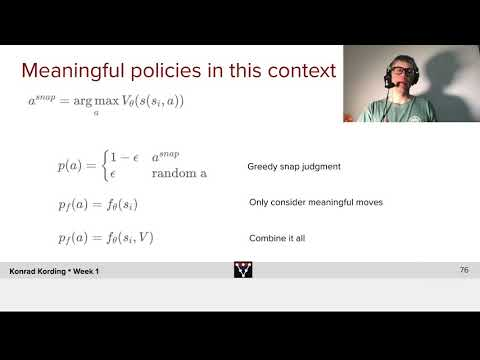

In [12]:
#@title Video: Potential policies
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="C6YWnynO9AM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video



The $\epsilon$-greedy agents above all make "snap judgments" by looking a single move ahead and evaluating the resulting board configuration. One problem with this is that all moves are tried from the current position, even if they are "obviously" bad. Ideally, we could look at a board and only evaluate the moves that look initially "sensible."

This leads to another kind of "snap judgment": a policy function. A policy is a function that takes in a board and outputs a probability distribution over possible moves without first "trying out" any of those moves.

Earlier, when you were playing Othello against classmates or against an AI, did you mentally try out every available move? Or did you only mentally simulate "promising" moves? What did you base that judgment on?

We'll start by looking at policy functions in isolation before returing to the idea of smart *searching* using a combination of policy functions to guide the search and value functions to score them (the Monte Carlo Tree Search or MCTS algorithm)


## Exercise 1: Hand-coding a policy agent

We're going to build an agent who samples moves from a policy function. The policy is a probability distribution over moves. The agent will *sample* from the policy to select a move.

First, we'll build a base class that works for all policies.


In [13]:
class PolicyAgentBase(ArtificialPlayer):
    """Base class for game-playing using a policy. Sub-classes need only provide
    a get_policy function.
    """

    def __init__(self, name=None, temperature:float=1.0):
        self.name = self.__class__.__name__ if name is None else name
        self.t = temperature
    
    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        """PolicyAgentBase.get_policy return a distribution over the board
        of "good" moves for the current player. Doesn't need to be normalized
        over even all legal (those are handled by PolicyAgentBase.select_move).

        Warning: Must not modify game state!
        """
        raise NotImplementedError("Must be implemented by sub-class!")

    def get_selected_move_index(self, policy):
        """Takes a 1d flattened policy for each board and outputs the index of
        the action selected, sampling with the appropriate temperature.
        
        Inputs: policy, a (n_games, n_moves) Tensor
        Outputs: choice_idx, a (n_games) Tensor with integers specifying
                 the action selected for each game (i.e. the column of policy)
        """
        if self.t < 1e-6:
            # Super low temperature is treated as greedy
            choice_idx = torch.argmax(policy, dim=1, keepdim=True)
        else:
            choice_idx = torch.multinomial(policy**(1/self.t), num_samples=1)
        return choice_idx    
    
    def select_move(self, game:OthelloGame):
        policy = self.get_policy(game)
        policy = policy * game._valid_moves.to(policy.device)
        flat_policy = policy.view(game.n_games, -1)
        # Place a dummy value into boards that have no legal moves
        no_moves = torch.sum(game._valid_moves.view(game.n_games, -1), dim=1) == 0
        flat_policy[no_moves, 0] = 1

        flat_choice_idx = self.get_selected_move_index(flat_policy)

        # Now we need to take this unrolled index and convert it into the x,y 
        # board position of the selected move
        i_max, j_max = flat_choice_idx // game.n, flat_choice_idx % game.n
        actions_ij = torch.cat([i_max, j_max], dim=1)
        # Pass on all games that had no valid moves
        actions_ij[no_moves, :] = -1
        return actions_ij
    
    def plot_policy(self, game, mask_legal=True):
        with torch.no_grad():
            policy = self.get_policy(game).cpu()
            if mask_legal:
                policy = policy * game._valid_moves.cpu()
            # Normalize it
            policy = policy / torch.sum(policy, dim=(1,2), keepdims=True)

            for g in range(game.n_games):
                plt.figure(figsize=(6,6))
                ax = plt.gca()
                im = plt.imshow(policy[g,:,:])
                plt.xticks([]); plt.yticks([])
                suffix = '(full board)' if not mask_legal else '(legal moves only)'
                plt.title(f'Policy heatmap {suffix}')
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
                plt.show()

Here is a very, very simple policy. It cares about all moves equally. Note that it doesn't need to return valid moves - masking out invalid moves is handled in `select_move` above. Also note that it doesn't need to normalize its probability distribution to 1. That is also handled in `select_move`.

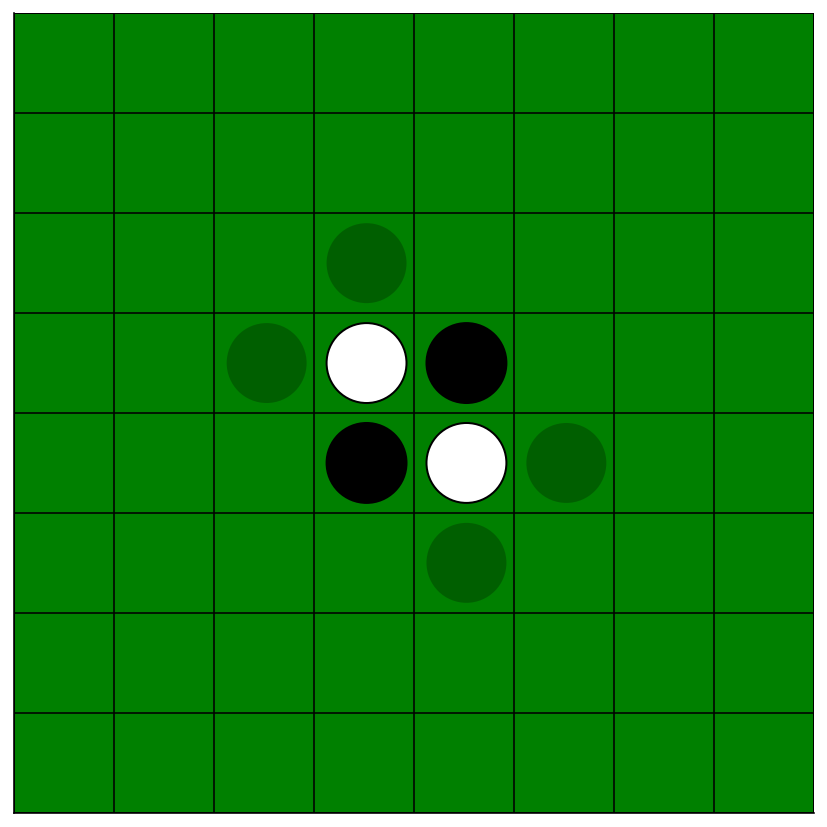

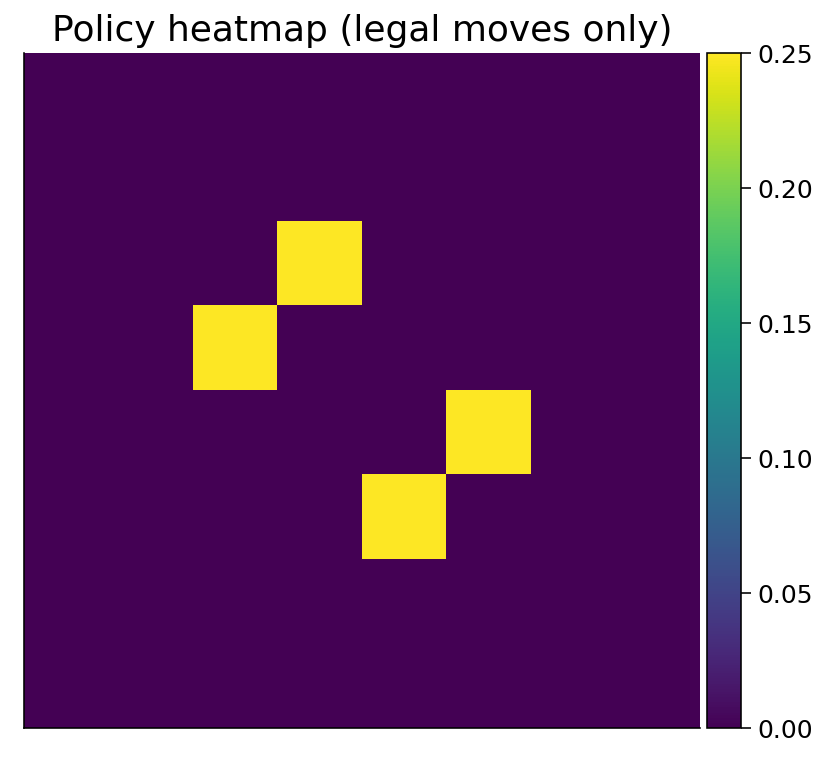

In [14]:
class UniformPolicyAgent(PolicyAgentBase):
    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        return torch.ones_like(game.boards)

game = OthelloGame(n_games=1, n=8)
game.render()
uniform_agent = UniformPolicyAgent()
uniform_agent.plot_policy(game, mask_legal=True)

Let's imagine creating a hand-coded function for a policy for Othello, just like you created one for value last week. Talk in your group and come up with a good strategy.

In [15]:
policy_strategy = "Play an action that reduces the greatest number of an opponent's occupation of the board. " #@param {type:"string"}

## Section 1.1: Making a policy agent

_Time estimate: 30 minutes since start_

Video available at https://youtube.com/watch?v=0pB3jdzRI0U


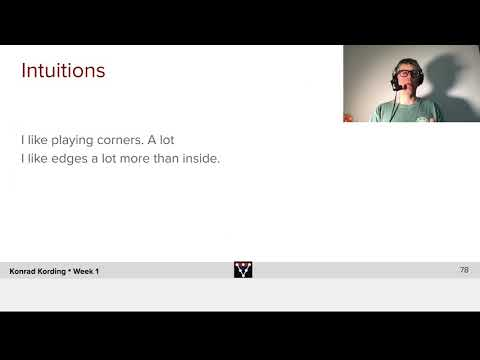

In [16]:
#@title Video: Handmade policies
param_list = ['policy_strategy']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

video = YouTubeVideo(id="0pB3jdzRI0U", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


We won't make you actually code out a hand-coded policy. This is a deep learning course, after all. Instead, we've provided a heuristic for you. This agent simply likes edges and corners better than the center of the board.

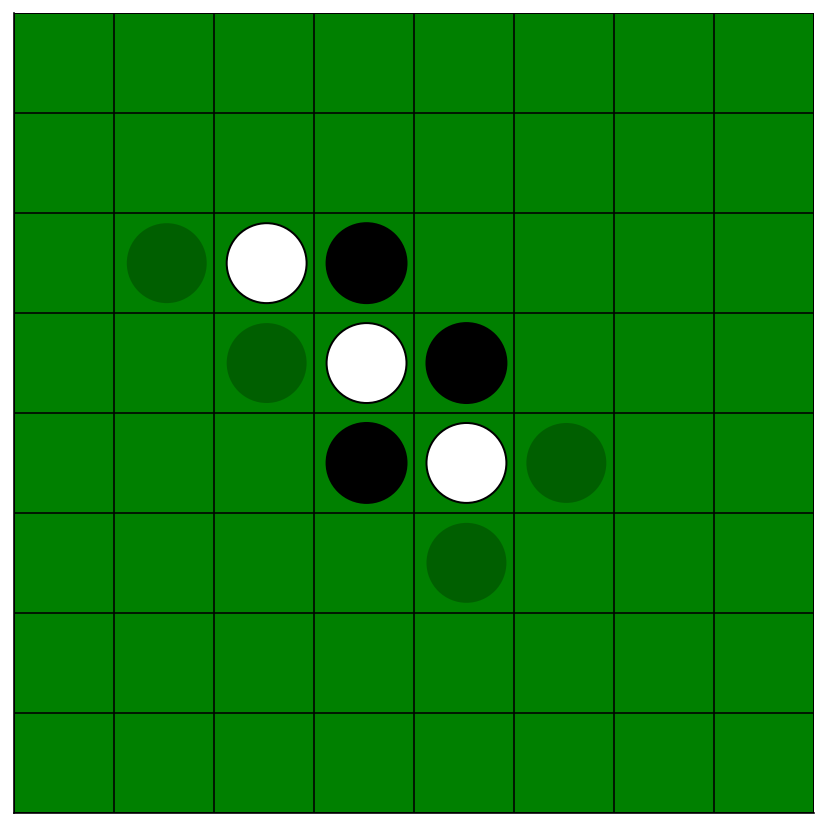

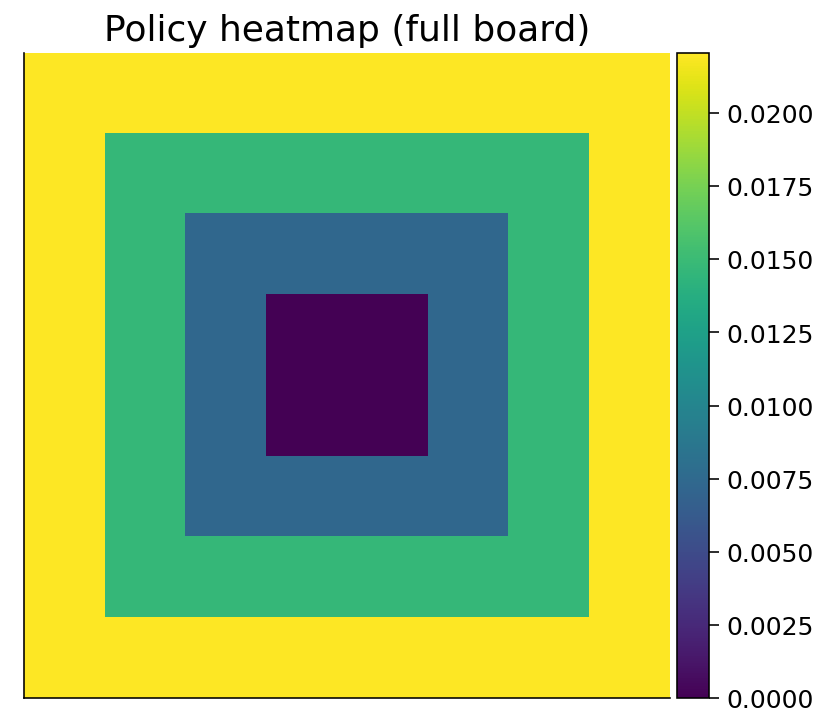

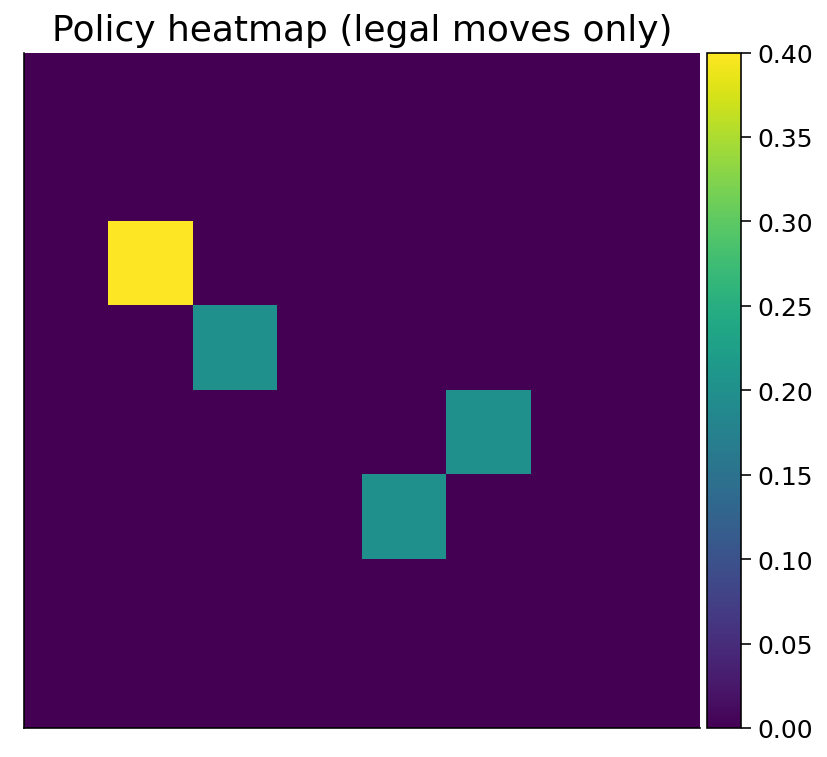

In [17]:
class MyPolicyAgent(PolicyAgentBase):
    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        """Input: game, an instance of OthelloGame
         Returns: policy a (n_games, n, n) Tensor. The distribution over the 
                  board of "good" moves for the current player. 
        """

        policy = torch.ones_like(game.boards)
        for i in range(game.n//2):
            policy[:, game.n//2-1-i, game.n//2-1-i:game.n//2+i] = i
            policy[:, game.n//2+i, game.n//2-1-i:game.n//2+i+1] = i
            policy[:, game.n//2-1-i:game.n//2+i+1, game.n//2-1-i] = i
            policy[:, game.n//2-1-i:game.n//2+i+1, game.n//2+i] = i
        return policy

game = OthelloGame(n_games=1, n=8)
game.step(game.get_available_actions()[0][0])
game.step(game.get_available_actions()[0][0])
game.render()
my_agent = MyPolicyAgent()
my_agent.plot_policy(game, mask_legal=False)
my_agent.plot_policy(game, mask_legal=True)

In [18]:
game.current_player

1

How do these policy-based snap-judgement agents compare against each other?

Or against the value-based agents?

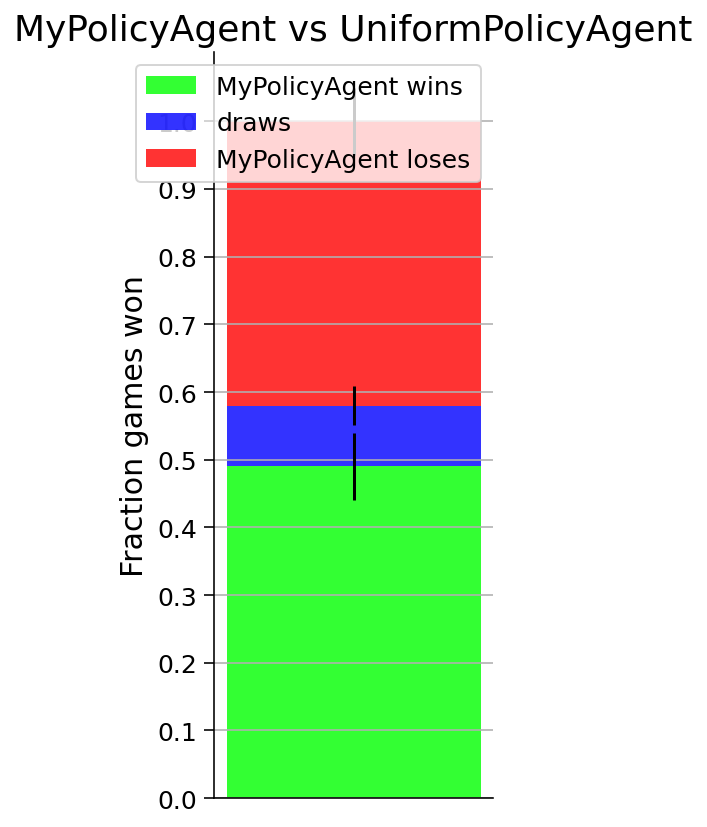

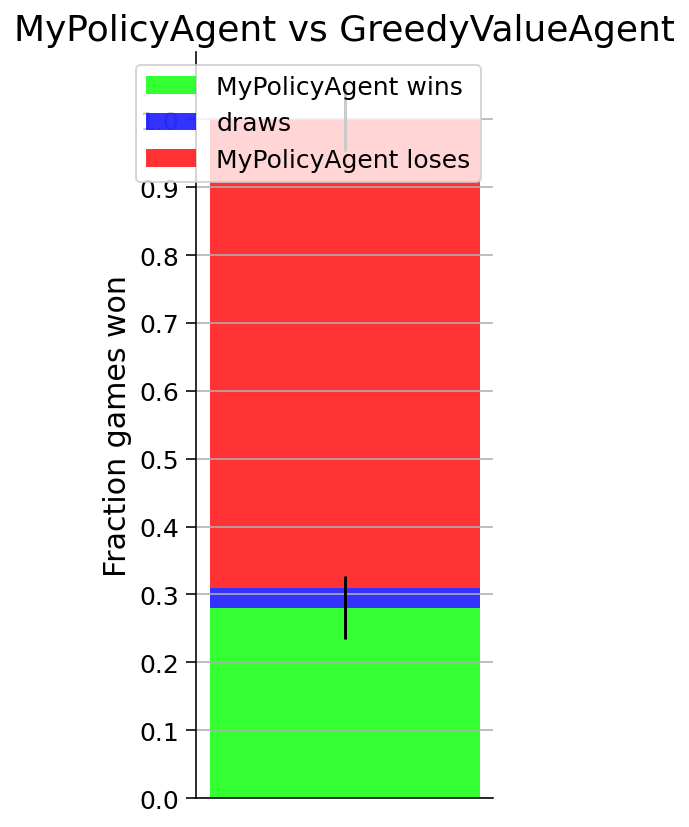

array([[28.,  3., 69.]])

In [19]:
uniform_agent = UniformPolicyAgent()
my_policy_agent = MyPolicyAgent()
heuristic_value_agent = EpsilonGreedyAgent(name="GreedyValueAgent")

win_statistics(my_policy_agent, uniform_agent)
win_statistics(my_policy_agent, heuristic_value_agent)

## Exercise 2: How can we train a policy network?


Video available at https://youtube.com/watch?v=MMzxB47l5bM


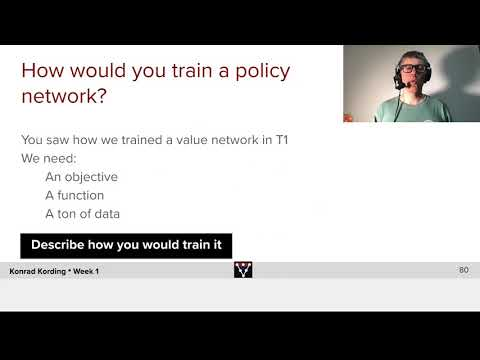

In [20]:
#@title Video: Training a Policy Network

video = YouTubeVideo(id="MMzxB47l5bM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Let's say we make a NN that takes in a board an outputs a distribution over board locations - a policy. Recall from the value network that training a NN requires 
1. a quantifiable objective to minimize, and 
2. a lot of data.

Can we formulate an appropriate objective function to train towards, and build a proper labeled training set?

Take 2 minutes in silence (before group discussion) and write down a strategy for training a neural network to output a good policy.

In [21]:
how_to_train_policy= 'Get lots of labelled training data where the labels denote a win or a loss. The objective function can then try to maximize the probability of winning. This has a tree-search feel to it as well.' #@param {type:"string"}

Now read out your strategies in your pod. 

Video available at https://youtube.com/watch?v=llgQ5EKAORg


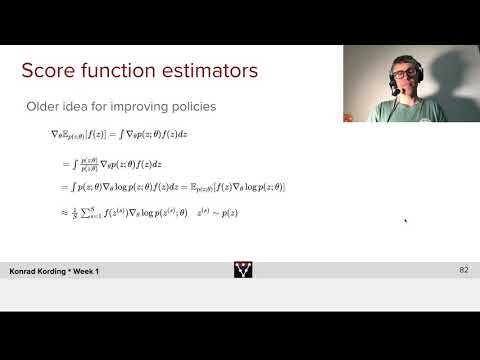

In [22]:
#@title Video: RL and historical ways of thinking
param_list = ['how_to_train_policy']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

video = YouTubeVideo(id="llgQ5EKAORg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video
    

---
# Section 2: Moving beyond snap-judgments: planning and tree-search

_Time estimate: 50 minutes since start_

Video available at https://youtube.com/watch?v=Mo2fwXqJGzM


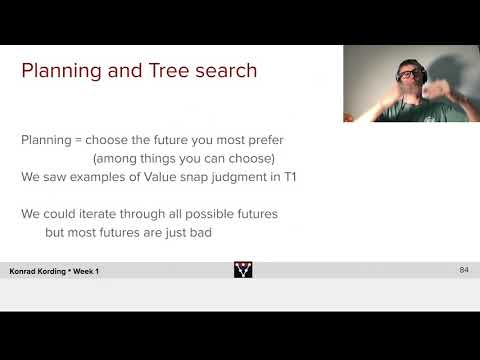

In [23]:
#@title Video: Trees that describe the future

try: t2;
except NameError: t2 = time.time()

video = YouTubeVideo(id="Mo2fwXqJGzM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Above, we saw examples of agents that play Othello entirely by "snap judgments". The Value-based agents looked one move ahead and evaluated that position. The Policy-based agents map directly from a board to a distribution of plausible actions without even looking a single step ahead.

A much more powerful way of selecting moves is to treat the policy as a "hunch" about what moves are good, then simulate a few steps into the future, scoring the result a few moves down the line using the value function.

Why do we need to use our policy "hunch" when planning, when all we are interested is the estimated value a few moves out? There are simply too many possible moves. Here we've created the move tree for just the first full turn.

In [24]:
#@markdown MCTSTree class and visualization tools (just run me - we'll see more on MCTS later)
import plotly.graph_objs as go
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

class MCTSTree(object):
    """Monte Carlo Tree Search. An MCTS object is initialized with a policy and
    value function.

    Search behavior is controlled using num_search (number of searches to run)
    and cpuct (explore/exploit hyperparameter)

    Based partially on github.com/suragnair/alpha-zero-general/
    """

    def __init__(self, policy_value_fun, n_games=1, n=8, num_search=100, cpuct:float=1.0):
        assert cpuct > 0, "cpuct parameter must be positive"
        assert num_search >= 1, "Must have >=1 simulation"
        self.pol_val_fun = policy_value_fun
        self.num_search = num_search
        self.cpuct = cpuct
        self.max_depth = 500
        self.n_games = n_games
        self.n = n
        self.init_tree()

        if self.n_games > 1 and self.__class__.__name__ == "MCTSTree":
            raise ValueError("The base MCTSTree class can only handle one game at a time!")
    
    def init_tree(self):
        # s refers to state, a to actions. States are used as dictionary keys
        # by calling state_key on single games.
        self.Ns = {}  # stores #times state s was visited
        self.Ls = {}  # stores list of legal moves at state s
        self.Ps = {}  # stores snap policy judgment at s: tensor same size as Ls
        self.Vs = {}  # stores snap value judgment at s: scalar tensor
        self.Tsa = {} # stores total sub-tree values for s: tensor same size as Ls where index i corresponds to Ls[s][i]
        self.Nsa = {} # stores #times edge s,a was visited: same format as Tsa
        # For debugging/visualization...
        self.Ksa = {} # stores a set of (action, child_idx) tuples from each parent node
        self.Bs = {} # stores board state as a tuple of integers for plotting
    
    def state_key(self, game:OthelloGame, player):
        # get_uid returns a [n_games] tensor of int64 hashes. Assume n_games=1
        # and grab the int out of the tensor.
        return game.get_uid(player).item()

    def count_child_visits(self, game):
        """Return visit count for children of the given game
        """
        s = self.state_key(game, game.current_player)
        counts = torch.zeros_like(game.boards)
        children = self.Ls[s]
        for k, (i,j) in enumerate(children):
            counts[0,i,j] = self.Nsa[s][k]
        return counts
    
    def run_searches(self, game):
        """Run self.num_searches searches from the given game position, extending
        whatever tree we already have.

        Note: nothing is returned, since the effect of this function is to
        expand the tree which is stored as instance variables.
        """
        for i in range(self.num_search):
            state = game.copy_state()
            self.single_search(game)
            game.paste_state(state)

    def single_search(self, game:OthelloGame):
        """This function performs one iteration of MCTS. It loops until a leaf 
        state (unvisited or end of game) is found. The action chosen at each
        step is one that has the maximum upper confidence bound (UCB).

        Note: nothing is returned, since the effect of this function is to
        expand the tree which is stored as instance variables.

        After returning, assume 'game' is irreversible altered. The caller is
        responsible for copying the game state as needed. (See @run_searches)
        """
        path = []
        for d in range(self.max_depth):
            s = self.state_key(game, game.current_player)

            # Record board position for plotting
            if s not in self.Bs:
                self.Bs[s] = tuple(int(v) for v in game.boards[0].flatten().cpu())
            
            # Count visit to this state
            self.Ns[s] = 1 if s not in self.Ns else self.Ns[s]+1

            is_unvisited = self.Ns[s] == 1
            is_leaf = is_unvisited or game.game_status == OthelloGame.OVER
            if is_leaf:
                # Found a leaf! Get ready to propagate value back through the
                # search path.
                if is_unvisited:
                    if game.game_status == OthelloGame.OVER:
                        # No guesswork on the value. Use the actual game outcome.
                        result = game.score_games()[0]
                        self.Vs[s] = result[0] if game.current_player == OthelloGame.PLAYER1 else result[1]
                    else:
                        # This is a *new* leaf. Run policy and value on this state.
                        pol, self.Vs[s] = self.pol_val_fun(game.boards, game.current_player)
                        self.Ls[s] = game.get_available_actions()[0]
                        # Store snap-policy judgment just over legal moves
                        self.Ps[s] = torch.tensor([pol[0,i,j] for (i,j) in self.Ls[s]])
                        # Initialize empty child counts from s
                        self.Nsa[s] = torch.zeros(len(self.Ls[s]))
                        self.Tsa[s] = torch.zeros(len(self.Ls[s]))
                # Note: value Vs[s] is from the perspective of the player whos
                # turn it is in state s, *not* from the perspective of whoever
                # just played a turn before.
                backup_value = self.Vs[s]
                break
            else:
                # We've been here before. Select next move according to UCB.
                legal_actions = self.Ls[s]
                if len(legal_actions) == 0:
                    next_action_idx, next_action = None, OthelloGame.PASS
                else:
                    # Q-value is average value = total value / number of visits
                    Qsa = self.Tsa[s] / self.Nsa[s]
                    # Wherever Nsa==0, set Q to (otherwise it is nan)
                    Qsa[self.Nsa[s] == 0] = 0.0
                    # UCB is a combination of Q values and snap-judgment policy.
                    # Note: for UCB purposes, this visit isn't complete yet, so subtract 1 from Ns
                    UCB = Qsa + self.cpuct * self.Ps[s] * math.sqrt(self.Ns[s] - 1) / (1 + self.Nsa[s])
                    # Argmax the UCB score for next action
                    next_action_idx = torch.argmax(UCB).item()
                    next_action = self.Ls[s][next_action_idx]
                
                # Book-keeping: keep track of all (s,a) pairs along the search path
                path.append((s, next_action_idx))

                # Advance to the next state
                game.step(next_action)
                
                # Store parent id -> (action, child id) map
                if next_action_idx is not None:
                    if s not in self.Ksa:
                        self.Ksa[s] = set()
                    self.Ksa[s].add((next_action, self.state_key(game, game.current_player)))
        else:
            # For...else syntax should be read as "no break" clause. We land
            # here if no leaf was ever encountered.
            raise RuntimeError("Never hit a leaf! This shouldn't happen!")
        
        # print("[DEBUG] ENDED SEARCH AT", s)
        # print("[DEBUG] PATH WAS", path)
        
        # Run back through the path updating states. Recall that values are always
        # from the perspective of whoever's turn it is when the board was evaluated.
        # Since player 1's gains are necessarily player 2's losses (AKA minimax),
        # we have to flip the sign of the value for each step back up the tree.
        while len(path) > 0:
            backup_value = -backup_value
            s, action_idx = path.pop()
            # print("[DEBUG] BACKUP", s, action_idx, self.Ls[s][action_idx])
            # print("[DEBUG] VALUE", backup_value)
            if action_idx is not None:
                self.Nsa[s][action_idx] = self.Nsa[s][action_idx] + 1
                self.Tsa[s][action_idx] = self.Tsa[s][action_idx] + backup_value
    
    def to_graph(self, game:OthelloGame, g_idx=0, max_depth:int=100):
        """Debugging helper. Retuns a networkx.DiGraph representation of the tree.
        """
        root = self.state_key(game, game.current_player)
        G = nx.DiGraph()
        G.add_node(root,
                player=game.current_player,
                value=self.Vs[root].item(),
                # hash=root, # for debugging only
                n=self.Ns[root])
        # queue contains tuples of (parent uid, child idx, child uid, depth, player)
        queue = [(root, act, ch, 1, 3-game.current_player) for act, ch in self.Ksa[root]]
        while len(queue) > 0:
            parent, act, child, depth, player = queue.pop()
            idx = [i for i in range(len(self.Ls[parent])) if self.Ls[parent][i] == act][0]
            G.add_node(child,
                    player=player,
                    value=self.Vs[child].item(),
                    # hash=child, # for debugging only
                    visits=self.Ns[child])
            G.add_edge(parent, child,
                    policy=self.Ps[parent][idx].item(),
                    visits=self.Nsa[parent][idx].item(),
                    q=self.Tsa[parent][idx].item()/self.Nsa[parent][idx].item(),
                    action=act)
            if depth < max_depth and child in self.Ksa:
                queue.extend([(child, a, ch, depth+1, 3-player) for a, ch in self.Ksa[child]])
        return G, root

def plot_mcts_tree(tree:MCTSTree, game:OthelloGame, max_depth:int=100, edge_width_range=(0.5,3), title=None, no_mcts_metadata=False):
    G, root = tree.to_graph(game, g_idx=0, max_depth=max_depth)
    
    # Based on https://plotly.com/python/network-graphs/

    # Compute x,y locations for each node that lays out the plot nicely
    layout = {}
    parents = [root]
    d=0
    while len(parents) > 0:
        children = []
        for i, p in enumerate(parents):
            layout[p] = (i+1)/(len(parents)+1), 1-d/max_depth
            if p in tree.Ksa:
                children.extend([k for _, k in tree.Ksa[p] if k is not None])
        d += 1
        parents = children
    
    min_width, max_width = edge_width_range

    edge_traces, edge_hovers = [], []
    for u,v in G.edges():
        x0, y0 = layout[u]
        x1, y1 = layout[v]
        norm = max(attr['visits'] for _, attr in G[u].items())
        edge_traces.append(go.Scatter(
            x=[x0, x1], y=[y0, y1], mode='lines',
            line={'width': min_width+(max_width-min_width)*G[u][v]['visits']/norm, 'color': 'black'}))
        edge_txt = [f"{k}={v}" for k,v in G[u][v].items()]
        if not no_mcts_metadata:
          edge_hovers.append(go.Scatter(
              x=[(x0+x1)/2], y=[(y0+y1)/2], mode='markers',
              marker={'color':'black', 'size':5},
              hoverinfo='text', text="<br>".join(edge_txt)))
          
    
    node_x, node_y, node_text, node_player = [], [], [], []
    for node in G.nodes():
        x, y = layout[node]
        node_x.append(x)
        node_y.append(y)
        node_player.append(G.nodes[node]['player'])
        node_txt = [f"{k}={v}" for k,v in G.nodes[node].items()]
        board_string = " ".join(OthelloGame.GAME_SYMBOLS[v] for v in tree.Bs[node]) if node in tree.Bs else "[no board saved]"
        board_string_2d = "<br>".join(board_string[2*i:2*(i+game.n)] for i in range(0, game.n**2, game.n))
        node_text.append(board_string_2d + "<br>" + "<br>".join(node_txt))
        if no_mcts_metadata:
          node_text[-1] = board_string_2d


    node_trace = go.Scatter(x=node_x, y=node_y, text=node_text, mode='markers', hoverinfo='text',
                            marker={'size':10,'cmin':1, 'cmax':2,
                                    'color': node_player,
                                    'colorscale': ['black', 'white'],
                                    'line': {'width': 2, 'color':'gray'}})
    
    fig = go.Figure(data=edge_traces+edge_hovers+[node_trace],
            layout=go.Layout(title='MCTS Tree' if title is None else title, titlefont_size=16, showlegend=False,
                            width=500*(1 if no_mcts_metadata else 1.5), height=400*(1 if no_mcts_metadata else 1.5),
                            hovermode='closest', hoverlabel={'bgcolor':'white'},
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    fig.show()

In [25]:
def naive_policy_value_fun(boards:torch.Tensor, whoami:torch.Tensor):
    pol = torch.ones_like(boards)
    val = torch.zeros_like(boards)[:,0,0]
    return pol, val

def plot_beginning_tree():
    game = OthelloGame()
    tree = MCTSTree(naive_policy_value_fun, num_search=17, cpuct=1.0)
    tree.run_searches(game)
    plot_mcts_tree(tree, game, title="Hover over markers to see boards", no_mcts_metadata=True)

plot_beginning_tree()

**Student response:** How many final board states are there for an 8x8 board? How many valid moves exist *on average* during the course of the game?

In [26]:
final_boards = "Assuming each square in the end has to be filled, 2^64 final board states seems like a decent approximation. " #@param {type:"string"}
average_valid_moves = "In the beginning there's 4 moves a player can make. This number can decrease as we fill the board up more, and/or reach the edges and corners. As an approximation, 4 moves a turn on average is a reasonable guess." #@param {type:"string"}


---
# Section 3: Monte-Carlo Tree Search (MCTS): a smart way to plan


_Time estimate: 65 minutes since start_

Video available at https://youtube.com/watch?v=Ibvgl1-TwQg


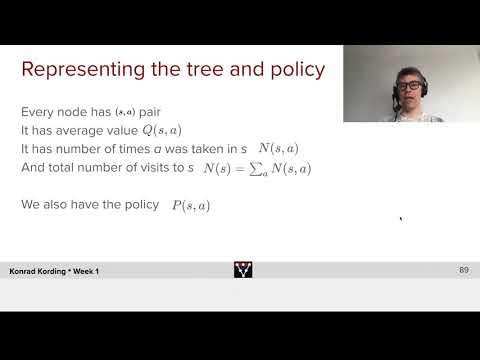

In [27]:
#@title Video: Monte Carlo Tree Search (MCTS)

param_list = ['final_boards', 'average_valid_moves']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

try: t3;
except NameError: t3 = time.time()

video = YouTubeVideo(id="Ibvgl1-TwQg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Even in Othello (let alone Go) here are far more game trees than can ever be explicitly tested. We need a way to test only promising paths. This is what MCTS does, and it is the core idea of AlphaZero. What is "promising" for MCTS is decided from a combination of game outcomes, value estimates, and policies. The value estimates and policies are where neural networks come in.

Today's tutorial of MCTS should be a review for you. Most of you saw MCTS in CIS 521 (Machine Learning). There are also many great resources online that you should consult if today's materials are confusing (we recommend [this](https://web.archive.org/web/20180623055344/http://mcts.ai/about/index.html), [this](https://web.stanford.edu/~surag/posts/alphazero.html), and [this](http://joshvarty.github.io/AlphaZero/)).


## Section 3.1: MCTS is a tree-growing algorithm
In the beginning of each game, MCTS starts with no tree. Then, each turn, MCTS grows its tree by a set number of nodes (for us, about 100). Each node is grown by starting from the root of the tree and then following a path (i.e. simulating gameplay) with a special equation for how actions are selected. This equation is called the **upper confidence bound** (UCB). It balances the policy, value, and visit counts to balance exploration and exploitation.

### The UCB

Each edge of the tree $(s,a)$ maintains the following attributes:
 - $Q(s,a)$, the average value after following action $a$.
 - $N(s,a)$, the number of times this edge has been taken.
 - $N(s) = \sum_aN(s,a)$, the number of times a node has been visited.

We also store the policy $P(s,a)$, which is expensive to compute and never changes. While growing nodes, MCTS chooses actions $a$ from each node $s$ by maximizing the UCB equation:

$$U(s,a)=Q(s,a) + c_{puct} P(s,a)\frac{\sqrt{N(s)}}{1+N(s,a)}$$

$c_{puct}$ is a hyperparameter that controls exploration.

When a node is expanded into new leaves, we encounter the reward (if the game ends) or an expected reward, a.k.a. a value estimate. This is progagated down to update all $Q(s,a)$ in the edges we just traversed.

### A metaphor

MCTS is like growing a real biological tree. Trees want to grow leaves to maximize sunlight (value). Growing leaves requires sugar in the form of sap, which needs to be pumped up from the root. How should a growing tree decide where to send sap? When a node $s$ receives sap, it sends it upwards depending on:
 1. The policy $P(s,a)$ (an initial hunch about where sunlight is, provided in our case by a Policy Network)
 2. The value of the next node $Q(s,a)$ (the average amount of sunlight we've seen by sending sap down this branch before, provided in our case by a Value Network)
 3. The number of times the next node has been visited already $N(s,a)$ (branches that have received little attention in the past get some "exploratory" sap)

When the sap reaches the final node, it grows new leaves. These leaves communicates the sunlight it received (the value) down to all of the nodes visited in this episode, which update their average value attribute ($Q$) with this new leaf value.

## Section 3.2: Exploring tree growth

Before we dig into the code, let's examine correct behavior starting from the root node. We'll need a policy and value function of the boards, of course. Let's choose a simple one: a uniform policy, and a value that is the simple `my_board_value` we defined above (fraction of the total pieces that are `whoami`).

In [28]:
def random_policy_value_fun(boards:torch.Tensor, whoami:torch.Tensor):
    pol = torch.ones_like(boards)
    val = my_board_value(boards, whoami)
    return pol, val

### The first 5 searches

We've built an `MCTSTree` class for you so we can see these trees. `MCTSTree` takes a value/policy function and a number of searches – how many times we send sap up to expand a node into new leaves.

In [29]:
game = OthelloGame()
tree = MCTSTree(random_policy_value_fun, num_search=5)
tree.run_searches(game)
plot_mcts_tree(tree, game, title="Hover over the edge and nodes")

Take a look at the visit count on each of the edges. Why do they sum to 4, even though we have completed 5 searches?

In [30]:
sum_to_4 = 'The first visit expands the root node, and then the subsequent 4 visits take us to 4 different boards.' #@param {type:"string"}

Look at the q values along the edges, and compare it to the values in the nodes (which just records the random `0.0` or `1.0` result of `random_policy_value_fun` on that node's board). Why is the sign inverted?

In [31]:
sign_of_q = "The end positions in all four branches favor Player 1 since there's more black pieces on those boards. This has not propagated up the tree to update the q-values." #@param {type:"string"}

### The next 5 searches

Video available at https://youtube.com/watch?v=ByX8cr9jKu4


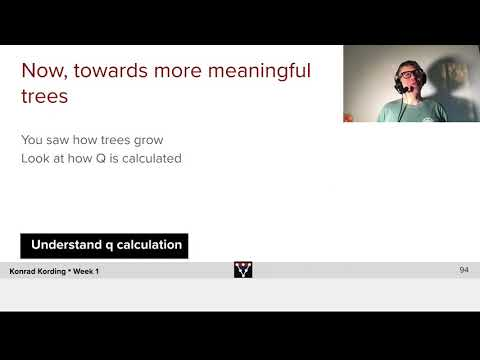

In [32]:
#@title Video: How Q is calculated

param_list = [ 'sum_to_4', 'sign_of_q']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

video = YouTubeVideo(id="ByX8cr9jKu4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Calling `tree.run_searches(game)` a second time continues adding to the previous tree. The number of new nodes is controlled by `tree.num_search`. The plot shows thicker lines along edges that have been visited more than their siblings in the tree.

Every time you run the next cell, it will add another 5 nodes to the tree.

In [33]:
tree.run_searches(game)
plot_mcts_tree(tree, game, title="Hover over the edge and nodes")

Look at the visit counts on the edges in the first row. Does it better reflect the policy, or the value estimate?

In [34]:
visit_counts_meaning = 'All four nodes that result from the root have the same value. The visit counts in the first row better reflect the policy since the edges cannot be distinguished by their end node values.' #@param {type:"string"}

## Section 3.3: The effect of a policy


_Time estimate: 80 minutes from start_

Video available at https://youtube.com/watch?v=7blA2q1pMoM


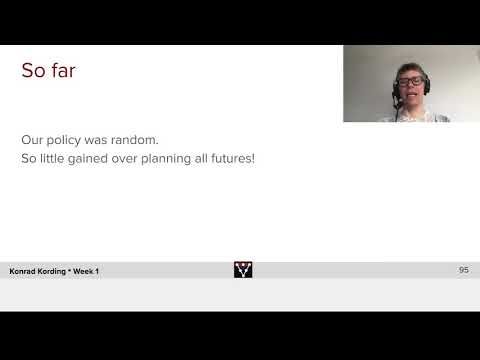

In [35]:
#@title Video: Nontrivial Policies
param_list = [ 'visit_counts_meaning']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

video = YouTubeVideo(id="7blA2q1pMoM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Before, our `random_policy_value_fun` had a uniform policy, and all exploration was driven by value. Let's try the opposite. We'll use an uninformative value function (always zeros) and policy that really likes some directions over others. 

In [36]:
def nonuniform_policy_value_fun(boards:torch.Tensor, whoami:torch.Tensor):
    pol = torch.bernoulli(torch.ones_like(boards)/2.) + 1e-6
    val = torch.zeros_like(boards[:,0,0])
    return pol, val

Now check out your policy in action:

In [37]:
game = OthelloGame()
tree = MCTSTree(nonuniform_policy_value_fun, num_search=30)
tree.run_searches(game)
plot_mcts_tree(tree, game, title="Hover over the edge and nodes")

## Section 3.4: The effect of $c_{puct}$

Video available at https://youtube.com/watch?v=EaKMI9Su4Wc


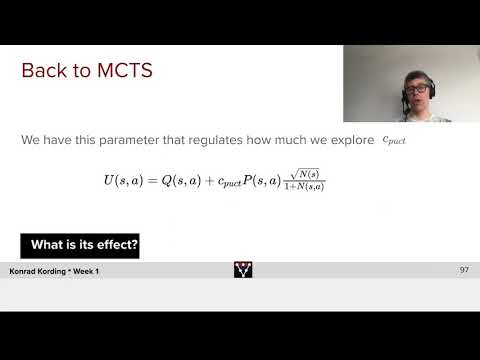

In [38]:
#@title Video: Exploration Parameter
video = YouTubeVideo(id="EaKMI9Su4Wc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Recall that while growing nodes, MCTS chooses actions $a$ from each node $s$ by maximizing the UCB equation (pasted from above):

$$U(s,a)=Q(s,a) + c_{puct} P(s,a)\frac{\sqrt{N(s)}}{1+N(s,a)}$$

Vary the value of $c_{puct}$ below. Try values close to 0 and quite large. What do you observe?

In [39]:
game = OthelloGame()
tree = MCTSTree(random_policy_value_fun, num_search=50, cpuct=1)
tree.run_searches(game)
plot_mcts_tree(tree, game, title="Hover over the edge and nodes")

In [40]:
effect_of_cpuct = 'cpuct = 0.001 leads to very little exploration. The same branch ends up being chosen with high frequency. cpuct = 1, by contrast, leads to a more uniform selection of branches.' #@param {type:"string"}

## Section 3.5: Selecting a move for actual gameplay

_Time estimate: 90 minutes since start. This next Exercise 3 should take 30 minutes for the tutorial to end on time._

Video available at https://youtube.com/watch?v=BC3cNXV-oKM


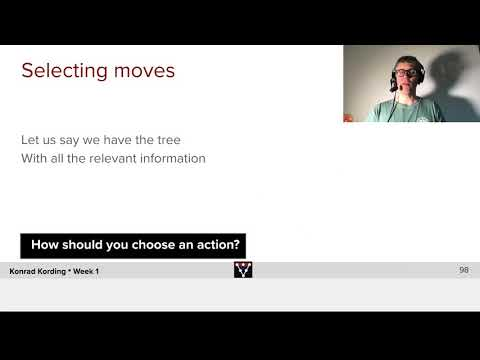

In [41]:
#@title Video: How to Choose an Action
param_list = [ 'effect_of_cpuct']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

video = YouTubeVideo(id="BC3cNXV-oKM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

After running many searches, MCTS will have built up a nice tree. How should we use that tree to select a move during actual gameplay?

Counterintuitively, we will **not** use the UCB equation. Otherwise, what would be the point of building up that whole exploratory tree? 

Instead, our agent will somehow *use* the information we gained during explanation to select the right move


### Exercise 3.a

Discuss and describe a possible strategy for using information obtained in an MCTS search tree for action selection. Keep it simple!

In [42]:
action_selection_strategy = 'Pick the branch that has the largest q-value.' #@param {type:"string"}

### Exercise 3.b

Build a subclass of `PolicyAgentBase` that uses an MCTS tree to select a move. Your agent's `get_policy` function (which is what you'll be implementing) should return a (possibly un-normalized) distribution over "good" moves. What "good" means in this context will be up to you. 

We're providing the MCTS tree implementation for you. An MCTS tree contains the following attributes, which are populated by calls to `run_searches`:

In [43]:
def init_tree(mcts):
    # s refers to state, a to actions. States are used as dictionary keys
    # by calling state_key on single games.
    mcts.Ns = {}  # stores #times state s was visited
    mcts.Ls = {}  # stores list of legal moves at state s as (i,j) index pairs
    mcts.Ps = {}  # stores snap policy judgment at s: tensor same size as Ls where index i corresponds to Ls[s][i]
    mcts.Vs = {}  # stores snap value judgment at s: scalar tensor
    mcts.Tsa = {} # stores total sub-tree values for s: tensor same size as Ls where index i corresponds to Ls[s][i]
    mcts.Nsa = {} # stores #times edge s,a was visited: same format as Tsa

def state_key(game:OthelloGame, player):
    # get_uid returns a [n_games] tensor of int64 hashes. Assume n_games=1
    # and grab the int out of the tensor.
    return game.get_uid(player).item()

The dictionaries all have keys that are boards... or rather, *hashes* of those boards. The hash is provided by the `state_key` function. 

    # number of times the search tried out each move.
    tree.Nsa[state_key(game, game.current_player)]  

If you instead want `Q` (the _average_ value of each action taken from each state), then you might consider something like

    key = state_key(game, game.current_player)
    Q = tree.Tsa[key] / tree.Nsa[key]


Now it's your turn. For now we are simplifying to a single game at a time since `MCTSTree` was not built to handle multiple games at once. So, the output of `get_policy` will be size `[1, n, n]`.

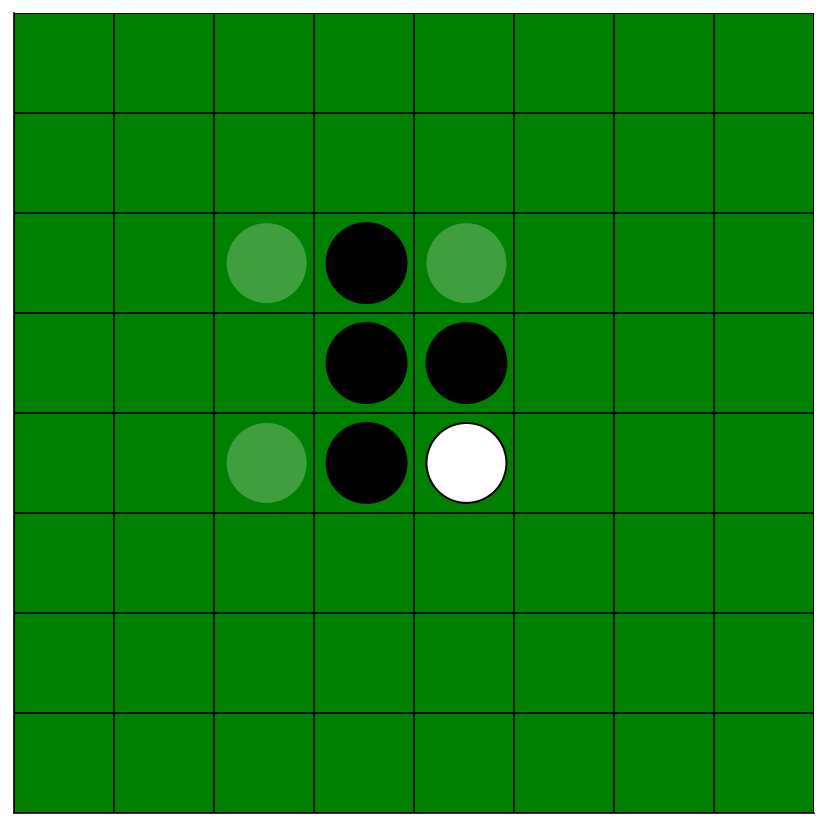

In [44]:
class MCTSAgent(PolicyAgentBase):
    def __init__(self, tree:MCTSTree, temperature=1.0):
        super(MCTSAgent, self).__init__(temperature=temperature)
        self.tree = tree # you'll need this!
    
    def new_game(self):
        """Reset the tree for new games.
        """
        self.tree.init_tree()

    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        """Input: game, an instance of OthelloGame
                  MCTStree, a built tree with the root as the starting board
         Returns: policy a (n_games, n, n) Tensor. The distribution over the 
                  board of "good" moves for the current player. 
        """
        # Run searches
        self.tree.run_searches(game)
        s = self.tree.state_key(game, game.current_player)
        policy = torch.zeros_like(game.boards)
        children = self.tree.Ls[s]
        for k, (i, j) in enumerate(children):
          policy[0, i, j] = self.tree.Tsa[s][k] / self.tree.Nsa[s][k]

        return policy

# uncomment to test code
game = OthelloGame()
tree = MCTSTree(random_policy_value_fun, num_search=50)
my_mcts_agent = MCTSAgent(tree)
act = my_mcts_agent.select_move(game)
game.step(act)
game.render()

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W1_AlphaZero/solutions/W1_Tutorial2_Solution_Ex3b.py)

*Example output:*

<img alt='Solution hint' align='left' width=416 height=416 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W1_AlphaZero/static/W1_Tutorial2_Solution_Ex3b.png>

### What AlphaZero does

Video available at https://youtube.com/watch?v=fiU-d9QBQdU


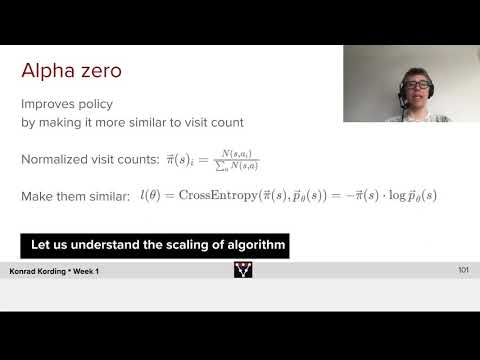

In [45]:
#@title Video: AlphaZero and Scaling
param_list = ['action_selection_strategy']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

try: t4; 
except NameError: t4 = time.time()

video = YouTubeVideo(id="fiU-d9QBQdU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

The standard MCTS algorithm uses visit counts as the actual policy. Move selection happens simply by examining the visit counts of the next available actions. You can think of MCTS as using a simple snap-judgment policy (and a value estimate and search) to obtain a new, better policy: the visit counts. 

The `MCTSTree` class in fact provides a `count_child_visits` function. Here is a minimalistic `MCTSAgent` who uses `count_child_visits` only. 

In [46]:
class MCTSAgent(PolicyAgentBase):
    def __init__(self, tree:MCTSTree, temperature=1.0):
        super(MCTSAgent, self).__init__(temperature=temperature)
        self.tree = tree # you'll need this!
    
    def new_game(self):
        """Reset the tree for new games.
        """
        self.tree.init_tree()

    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        """Input: game, an instance of OthelloGame
                  MCTStree, a built tree with the root as the starting board
         Returns: policy a (n_games, n, n) Tensor. The distribution over the 
                  board of "good" moves for the current player. 
        """
        # Run searches
        self.tree.run_searches(game)
        # The policy is proportional to visit counts of the children
        return self.tree.count_child_visits(game)

---
# Section 4: Using MCTS to training a policy (and a value)

_Time estimate: 120 minutes since start._



AlphaZero improves its policy network (used for tree exploration) by making it more similar to the MCTS visit counts. Let the output of a policy network with parameters $\theta$ be $\vec p_\theta(s)$. Then, let the (normalized) visit counts be the vector $\vec\pi(s)$ with entries $\vec \pi(s)_i = \frac{N(s,a_i)}{\sum_a N(s,a)}$. The loss function we'll minimize is:
$$ l(\theta) = \textrm{CrossEntropy}(\vec\pi(s), \vec p_\theta(s))\\ = -\vec\pi(s) \cdot \log \vec p_\theta(s)$$

The loss function for a value network is the same as before: the mean-squared error from a value estimate to the actual outcome of the game under *real* (i.e. under $\vec\pi(s)$) play.

## Exercise 4: How long will it take to train?

How long does it take to build an MCTS tree? This will depend on your choice of `policy_value_fun`, undoubtely. But we can get an approximate time estimate.


In [47]:
tree = MCTSTree(random_policy_value_fun, num_search=50)

%timeit tree.run_searches(game)

1 loop, best of 3: 725 ms per loop


Try changing the number of searches. What sort of scaling do you observe?

In [73]:
search_scaling = 'Doubling the number of searches from 50 to 100, changes the run time from 725 ms to 1.87 s which is more than double.' #@param {type:"string"}

Now, imagine that we will be training a network for 1,000 iterations, each with a batch size of 128 games and 50 searches. (Our `MCTSTree` above only builds 1 tree at time - no parallelization). How long will that take?

Again, this is a lower bound (since we are using our heuristics instead of our neural networks).

In [48]:
train_time_bound = '1000 * 128 * 0.725 s  = 92800 seconds which is approximately 1 day.' #@param {type:"string"}

How long does a NN take to evaluate, anyways? Remember we defined `ValueNet()` above. How long does it take to evaluate - and how does that affect your time estimate?


In [49]:
n_games = 1
game = OthelloGame(n_games=n_games)
value_net = ValueNet().cuda()

# warm things up (pytorch does some compilation/optimization the first time
# a function is called)
value_net(game.boards)
whoami = torch.ones(n_games).cuda()

%timeit my_board_value(game.boards, whoami)
%timeit value_net(game.boards)

1000 loops, best of 3: 425 µs per loop
1000 loops, best of 3: 367 µs per loop


In [50]:
adjusted_train_time_bound = '1000 * 128 * 50 * 367 us = 2349 seconds which is approximately 40 minutes.' #@param {type:"string"}

Now, as a teaser, run this plot to observe how these evaluation times change when run in parallel across boards.

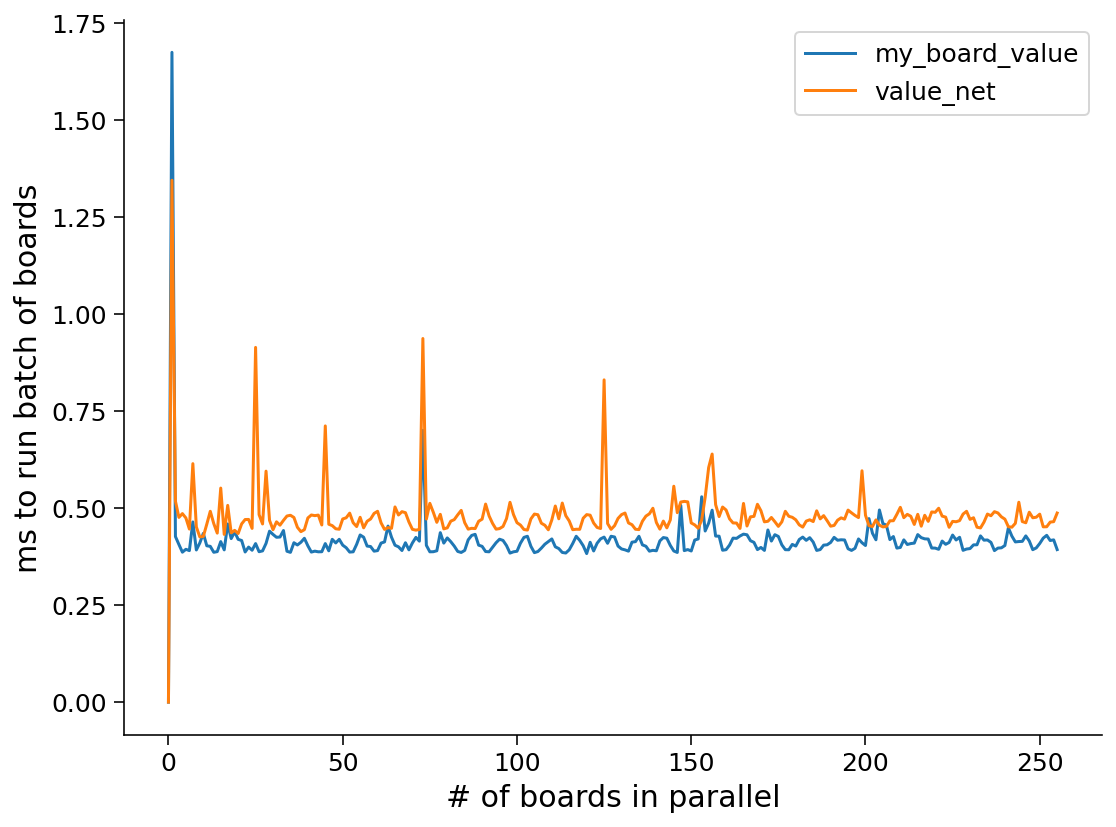

In [51]:
#@markdown Time vs. batch size (run to plot)
timings = np.zeros((256,2))
for n_games in range(1,256):
    game = OthelloGame(n_games=n_games)
    whoami = torch.ones(n_games).cuda()
    t0 = time.time()
    my_board_value(game.boards, whoami)
    t1 = time.time()
    value_net(game.boards)
    t2 = time.time()
    timings[n_games, :] = (t1-t0, t2-t1)
plt.plot(timings*1000)
plt.ylabel("ms to run batch of boards")
plt.xlabel("# of boards in parallel")
plt.legend(["my_board_value","value_net"])
plt.show()

This should convince you that computing in parallel is probably the right way to go.


---
# Section 5: Parallel MCTS

_Time estimate: 130 minutes from start_

Video available at https://youtube.com/watch?v=P-bhG9BXPgo


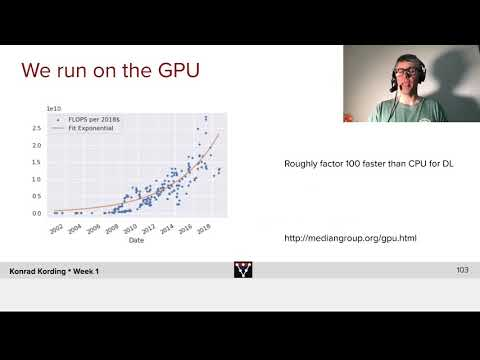

In [76]:
#@title Video: Running MCTS in Parallel
param_list = ['search_scaling', 'train_time_bound', 'adjusted_train_time_bound']
for param in param_list:
    if param not in locals():
       raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

try: t5; 
except NameError: t5 = time.time()

video = YouTubeVideo(id="P-bhG9BXPgo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

As you calculated, it will be absolutely crucial to speed up serial tree building. What can we parallelize? What can we speed?

The easiest thing to parallelize over is the games. In fact, we've been doing this all week! Below, we've built some functions that run MCTS in parallel over the boards in an `OthelloGame`.

Thus far the `MCTSTree` is implemented in very readable Python. This is for your sake! However, this means that 1) it operates one board at a time, and 2) all of the attributes are located on the CPU. We'd rather run everything on a GPU. Next, we will define such an all-GPU MCTS agent.


In [52]:
#@markdown CUDA helper kernel (just run me)

@cuda.jit
def cuda_index_of(values, table_entries, table_lengths, indices, add_new):
    """Naive linear search to find the index(es) of the given value(es). Runs in
    parallel: multiple tables and values can be searched at once. Results are
    stored in 'indices'. If add_new=True and an item isn't found, it is appended
    to the table and the new index is returned. If add_new=False, then -1 is used
    to mean 'not found'.

    Uses block indexing, so call with cuda_index_of[num_tables,1](...)
    """
    bx = cuda.blockIdx.x
    max_search = table_lengths[bx]
    val = values[bx]

    for i in range(max_search):
        if table_entries[bx, i] == val:
            indices[bx] = i
            return

    # Not found! either add a new entry or return -1
    if add_new:
        table_entries[bx, max_search] = val
        table_lengths[bx] = table_lengths[bx] + 1
        indices[bx] = max_search
    else:
        indices[bx] = -1

def test_cuda_index_of():
    table = torch.zeros(2, 10, dtype=torch.int64, device='cuda')
    hashes = torch.zeros(2, dtype=torch.int64, device='cuda')
    lengths = torch.zeros(2, dtype=torch.int32, device='cuda')
    indices = torch.zeros(2, dtype=torch.int32, device='cuda')

    hashes[0] = 42
    hashes[1] = 101

    # Empty table --> results should have index -1 and table and lengths should be unchanged
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), False)
    assert torch.all(indices == -1)
    assert torch.all(lengths == 0)
    assert torch.all(table == 0)

    # Same inputs except now add_new=True. Indices should be 0 (1st element) and
    # table and lengths should be updated
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 0)
    assert torch.all(lengths == 1)
    assert torch.all(table[:,0] == hashes)
    assert torch.all(table[:,1:] == 0)

    # add_new a second time with same inputs --> no effect
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 0)
    assert torch.all(lengths == 1)
    assert torch.all(table[:,0] == hashes)
    assert torch.all(table[:,1:] == 0)

    # Another round of new values, add_new=False
    hashes[0] = 11
    hashes[1] = 2021
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), False)
    assert torch.all(indices == -1)
    assert torch.all(lengths == 1)
    assert torch.all(table[:,0] == torch.as_tensor([42, 101], device='cuda'))
    assert torch.all(table[:,1:] == 0)

    # Another round of new values, add_new=True
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 1)
    assert torch.all(lengths == 2)
    assert torch.all(table[:,0] == torch.as_tensor([42, 101], device='cuda'))
    assert torch.all(table[:,1] == torch.as_tensor([11, 2021], device='cuda'))
    assert torch.all(table[:,2:] == 0)

    # add_new again --> no effect
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 1)
    assert torch.all(lengths == 2)
    assert torch.all(table[:,0] == torch.as_tensor([42, 101], device='cuda'))
    assert torch.all(table[:,1] == torch.as_tensor([11, 2021], device='cuda'))
    assert torch.all(table[:,2:] == 0)

    # One new one old, add_new=False
    hashes[0] = 12345
    hashes[1] = 101
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), False)
    assert torch.all(indices == torch.as_tensor([-1, 0], device='cuda'))
    assert torch.all(lengths == torch.as_tensor([2, 2], device='cuda'))
    assert torch.all(table[:,:2] == torch.as_tensor([[42,11],[101,2021]], device='cuda'))
    assert torch.all(table[:,2:] == 0)

    # One new one old, add_new=True
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == torch.as_tensor([2, 0], device='cuda'))
    assert torch.all(lengths == torch.as_tensor([3, 2], device='cuda'))
    assert torch.all(table[:,:3] == torch.as_tensor([[42,11,12345],[101,2021,0]], device='cuda'))
    assert torch.all(table[:,3:] == 0)

    # add_new again --> no effect
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == torch.as_tensor([2, 0], device='cuda'))
    assert torch.all(lengths == torch.as_tensor([3, 2], device='cuda'))
    assert torch.all(table[:,:3] == torch.as_tensor([[42,11,12345],[101,2021,0]], device='cuda'))
    assert torch.all(table[:,3:] == 0)

    print("TEST PASSED")

test_cuda_index_of()

TEST PASSED


In [53]:
#@markdown Define the ParallelMCTSTree class
class ParallelMCTSTree(MCTSTree):
    """Same function as MCTSTree, but parallelized over games, and searches
    live entirely on the GPU so there is no GPU<->CPU transfer bottleneck.

    policy_value_fun must also be able to accept and return entirely GPU tensors.

    Overrides init_tree, count_child_visits, single_search, to_graph, and
    state_key, but inherits run_searches and is otherwise functionally identical
    """
    INITIAL_TREE_SIZE = 256

    def __init__(self, *args, **kwargs):
        if 'debug' in kwargs:
            self._debug = kwargs['debug']
            del kwargs['debug']
        else:
            self._debug = False
        super(ParallelMCTSTree, self).__init__(*args, **kwargs)
        # Helper for slicing into the n_games dimension, since writing
        # torch.arange(self.n_games) over and over again is ugly.
        self._g_idx = torch.arange(self.n_games)
    
    def state_key(self, game:OthelloGame, player):
        # Whereas MCTSTree returns the .item() of a single game hash, here
        # we want all of them. Calling get_uid with out=self.cur_hash deposits
        # the result in the memory already owned by self.cur_hash and
        # self._cuda_cur_hash. The 'return' is redundant; it returns self.cur_hash
        # A call to _set_idx_to_hash(...) is still required to line up cur_idx
        # with cur_hash!
        return game.get_uid(player, out=self.cur_hash)
    
    def _set_idx_to_hash(self, add_new):
        """Set self.cur_idx to the index in the lookup_hash table that matches
        self.cur_hash. If add_new is True, creates a new table entry for unseen
        hashes. If add_new is false, then cur_idx will be -1 if unseen.
        """
        cuda_index_of[self.n_games, 1](self._cuda_cur_hash,
                                       self._cuda_lookup_hash,
                                       self._cuda_num_nodes,
                                       self._cuda_cur_idx,
                                       add_new)

    def init_tree(self):
        """Override MCTSTree.init_tree. Rather than python dicts, we do all
        tree book-keeping using GPU tensors.

        The idea is to pre-allocate space for a small-ish tree. As we search, if
        the data structures for the tree fill up, we double its allocated space
        and copy data over (see _expand_tree and _expand_tree_if_full)
        """
        # Clear the GPU memory before trying to allocate big tensors. Otherwise,
        # GPU memory fills up and we get esoteric error messages about "CUDA
        # device-side assertion failure"
        torch.cuda.empty_cache()
        # Allocate a tree with space for INITIAL_TREE_SIZE nodes. During search,
        # we will expand the memory as needed.
        self._tree_size = ParallelMCTSTree.INITIAL_TREE_SIZE
        self.Ns  = torch.zeros(self.n_games, self._tree_size, dtype=torch.float32, device='cuda') # One count per game per node
        self.Vs  = torch.zeros(self.n_games, self._tree_size, dtype=torch.float32, device='cuda') # One value per game per node
        self.Ps  = torch.zeros(self.n_games, self._tree_size, self.n, self.n, dtype=torch.float32, device='cuda') # Per-game, per-node, snap judgment policy output
        self.Tsa = torch.zeros(self.n_games, self._tree_size, self.n, self.n, dtype=torch.float32, device='cuda') # Per-game, per-node, per-position, sum of sub-tree values
        self.Nsa = torch.zeros(self.n_games, self._tree_size, self.n, self.n, dtype=torch.int32, device='cuda') # Per-game, per-node, per-position, visit counts
        self.lookup_hash = torch.zeros(self.n_games, self._tree_size, dtype=torch.int64, device='cuda') # Lookup table of board hashes
        self.cur_hash = torch.zeros(self.n_games, dtype=torch.int64, device='cuda') # Helper during search: current hash
        self.cur_idx = torch.zeros(self.n_games, dtype=torch.int64, device='cuda') # Helper during search: current index corresponding to cur_hash
        self.num_nodes = torch.zeros(self.n_games, dtype=torch.int32, device='cuda') # How many nodes we have so far to cap the search through lookup_hash
        if self._debug:
            # Only while in debug mode: keep a dictionary of parent->child UIDs
            # just like in the MCTSTree parent class. This requires GPU->CPU
            # data transfer so it is disabled by default. But it is necessary
            # for to_graph().
            self.Ksa = {}
            # Also keep a record of uid -> board state for visualization
            self.Bs = {}

        # Make _cuda_X wrappers around variables involved in hash lookups
        to_wrap = ['lookup_hash', 'cur_hash', 'cur_idx', 'num_nodes']
        for var in to_wrap:
            self.__dict__['_cuda_' + var] = torch2cuda(self.__dict__[var])
    
    def _expand_tree_if_full(self):
        buffer = 2 # Give some wiggle room just in case
        if self.num_nodes.max() >= self._tree_size - buffer:
            self._expand_tree()
    
    def _expand_tree(self):
        # print(f"[DEBUG] resizing tree from {self._tree_size} to {self._tree_size*2}")
        old_size = self._tree_size
        self._tree_size *= 2

        # Make a copy of each of the to_copy variables, expanding them along
        # dimension 1 to twice their previous size.
        to_copy = ['Ns', 'Vs', 'Ps', 'Tsa', 'Nsa', 'lookup_hash']
        for var in to_copy:
            old_tensor = self.__dict__[var]
            sz = list(old_tensor.size())
            assert sz[1] == old_size, f"Expected {var} to have dimension 1 size {self._tree_size} but was {sz[1]}. What gives?"
            sz[1] = self._tree_size
            new_tensor = torch.zeros(tuple(sz), dtype=old_tensor.dtype, device=old_tensor.device)
            new_tensor[:, :old_size, ...] = old_tensor
            self.__dict__[var] = new_tensor
        
        # Note we didn't touch cur_hash, cur_idx, or num_nodes so those can stay as they were
        to_wrap = ['lookup_hash']
        for var in to_wrap:
            self.__dict__['_cuda_' + var] = torch2cuda(self.__dict__[var])
    
    def count_child_visits(self, game:OthelloGame) -> torch.Tensor:
        # First, get the hash and index of the given game
        self.state_key(game, game.current_player)
        self._set_idx_to_hash(add_new=False)
        # Sanity check that all states do in fact exist in the table
        if torch.any(self.cur_idx == -1):
            raise ValueError("Failed to find a node! This shouldn't happen!")
        # Once index_of completes, we have the index into the nodes table per
        # game stored in self.cur_idx
        return self.Nsa[self._g_idx, self.cur_idx, :, :]

    def single_search(self, game:OthelloGame):
        # Path logs the (state, action) pairs along search paths. State is a
        # copy of cur_idx, and action is a [n_games,2] tensor. Both live on GPU.
        path = []

        # Each search (probably) adds a node. Expand the tree's memory if it's
        # close to filling up
        self._expand_tree_if_full()

        # Keep selecting moves until every game hits a leaf. We flag a game as
        # being at a leaf by setting game_status=OVER, even though it might not
        # really be over.

        # Pre-allocate actions tensor (init to zero so the did_pass test is
        # False on the 1st loop iteration)
        actions = torch.zeros(self.n_games, 2, dtype=torch.int32, device='cuda')
        # Pre-allocate boolean mask indicating which games need "expansion" aka
        # need the policy_value_function to be called on them. We don't expand
        # end-of-game states after their first visit.
        needs_expansion = torch.zeros(self.n_games, dtype=torch.bool, device='cuda')
        # Keep track of which game states are OVER for real (because leaf states
        # are flagged as OVER without really being over)
        is_terminal = torch.zeros(self.n_games, dtype=torch.bool, device='cuda')
        # Different games may hit leaves at different times, meaning they may
        # have different 'current_player' values! leaf_player keeps track of who
        # 'current_player' was each time we hit a leaf. Note: if player A plays
        # a move that results in a novel state (a leaf), then leaf_player will
        # be player B because that's whose turn it is _in the state being
        # evaluated_. So leaf_player is set to player B. Similarly, if player A
        # plays the final PASS move that ends the game, then player B is again 
        # the leaf_player.
        leaf_player = torch.zeros(self.n_games, dtype=torch.int64, device='cuda')
        depth = 0
        while depth < self.max_depth and torch.any(leaf_player == 0):
            depth += 1

            # Compute hashes for each game's current state -> result stored in
            # self.cur_hash. 
            self.state_key(game, game.current_player)
            # Lookup node index by hash -> result stored in self.cur_idx. Set
            # add_new to True to add this state to the table if it didn't
            # already exist
            self._set_idx_to_hash(add_new=True)
            # print(f"[DEBUG] Depth {depth} hash {self.cur_hash.cpu().numpy()}")
            # print(f"[DEBUG] Depth {depth} index {self.cur_idx.cpu().numpy()}")

            # print("[DEBUG]" + str(depth) + "  "*depth + f"TREE SIZE {self.num_nodes.max().item()}/{self._tree_size}; INDEX {self.cur_idx.max().item()}")
            if self.cur_idx.max() >= self._tree_size-1:
                raise RuntimeError("TREE IS FULL! This should not happen!")

            # Book-keeping for plotting
            if self._debug:
                for g in range(self.n_games):
                    s = self.cur_hash[g].item()
                    self.Bs[s] = tuple(game.boards[g].cpu().int().flatten().numpy())

            #########################
            ### DETECT NEW LEAVES ###
            #########################

            # Did we hit any new leaves? If so, mark them as leaves that need
            # expanding. (This does apply to end-of-game states that we're
            # seeing for the first time)
            needs_expansion = needs_expansion | (self.Ns[self._g_idx, self.cur_idx] == 0)
            # We can tell that this leaf was *just* encountered because it will
            # being the state of both needs_expansion but also ACTIVE. Record
            # who the player is at the time of encountering this leaf.
            is_new_leaf = needs_expansion & (game.game_status == OthelloGame.ACTIVE)
            # Flag all new leaves as OVER to freeze their board state.
            game.game_status[is_new_leaf] = OthelloGame.OVER
            # Record leaf_player: whose turn is it *now* ("player B" in the
            # comments above)
            leaf_player[is_new_leaf] = game.current_player

            # Detect games that *just* ended and store whose turn it is *now*
            # ("player B" in above comments)
            just_ended = (game.game_status == OthelloGame.OVER) & (leaf_player == 0)
            # Mark this game as in a "terminal" state
            is_terminal = is_terminal | just_ended
            # Record whose turn it is
            leaf_player[just_ended] = game.current_player

            ########################
            ### INCREMENT VISITS ###
            ########################

            # Increment visit count unless the previous move was a PASS, in which
            # case we're seeing the same state over and over again but it is not
            # a new visit.
            did_pass = actions[:,0] == -1
            self.Ns[self._g_idx[~did_pass], self.cur_idx[~did_pass]] = \
                self.Ns[self._g_idx[~did_pass], self.cur_idx[~did_pass]] + 1

            # We can skip the rest of the loop if everything is done. This is
            # important to ensure that path.append() was called exactly as many
            # times as game.step().
            if torch.all(game.game_status == OthelloGame.OVER):
                # print(f"[DEBUG] BREAKING on {depth}")
                break

            ############################
            ### UCB ACTION SELECTION ###
            ############################
            
            # For all non-leaf games, select another move using max of UCB.
            T = self.Tsa[self._g_idx, self.cur_idx, ...]
            N = self.Nsa[self._g_idx, self.cur_idx, ...]
            P = self.Ps[self._g_idx, self.cur_idx, ...]
            Ntot = self.Ns[self._g_idx, self.cur_idx].view(self.n_games,1,1) - 1 # For UCB purposes, this visit isn't complete yet, so subtract 1
            # Q-value is average value = total value / number of visits, or zero
            # if the (s,a) pair has not yet been tried. Shape is [n_games, n, n]
            Q = T/N
            Q[N==0] = 0
            # UCB is a combination of Q values and snap-judgment policy. Shape
            # is [n_games, n, n]
            UCB = Q + self.cpuct * P * torch.sqrt(Ntot) / (1 + N)
            UCB.masked_fill_(game._valid_moves == 0, float('-inf'))
            # Argmax the UCB score for next action
            next_action_flat_idx = torch.argmax(UCB.view(self.n_games, -1), dim=1)
            actions[:,0], actions[:,1] = next_action_flat_idx // self.n, next_action_flat_idx % self.n

            # Pass if there were no moves available or if the game is OVER. This
            # includes games that are flagged as leaves.
            do_pass = torch.all(game._valid_moves.view(self.n_games, -1) == 0, dim=1) | (game.game_status == OthelloGame.OVER)
            actions[do_pass, :] = -1

            ##############################
            ### RECORD ACTION AND STEP ###
            ##############################
            
            # Book-keeping: keep track of all (state idx, action) tuples along
            # the search path so we can back-up values later.
            path.append((self.cur_idx.clone(), actions.clone()))

            if self._debug:
                # If in debug mode, make a copy of the 'parent' hash value
                parent_hash = self.cur_hash.cpu().numpy()

            # print(f"[DEBUG] Depth {depth} actions are {actions.cpu().numpy()}")

            # Advance to the next state.
            game.step(actions)

            # When in debug mode, keep track of set of parent->child hashes
            if self._debug:
                child_hash = game.get_uid().cpu().numpy()
                actions_copy = actions.cpu().int().numpy()
                # Record parent hash -> set of tuples of (action, child hashes)
                for g in range(self.n_games):
                    s = self.cur_hash[g].item()
                    # Get action as a tuple of (row,col) integers
                    act = tuple(actions_copy[g,:].flatten())
                    if do_pass[g]:
                        continue
                    elif parent_hash[g] in self.Ksa:
                        self.Ksa[s].add((act, child_hash[g]))
                    else:
                        self.Ksa[s] = {(act, child_hash[g])}

        # After loop: ensure hashes and indices are up to date with game states.
        # Importantly, state_key depends on who the player is. Make sure all
        # hashes are relative to the leaf_player!
        self.state_key(game, leaf_player)
        self._set_idx_to_hash(add_new=True)
        # print(f"[DEBUG] After loop, hashes are {self.cur_hash}")
        # print(f"[DEBUG] ...and indices are {self.cur_idx}")

        # Sanity check that there is a leaf_player for all games
        # print(f"[DEBUG] leaf_player = {leaf_player.cpu().numpy()}")
        assert torch.all(leaf_player > 0), "Missing leaf player! This shouldn't happen!"

        # Prepare back-up values, which will all be from the perspective of
        # 'leaf_player'. Begin with the final-outcome value which will be used
        # for terminal states.
        backup_value = game.score_games()[self._g_idx, leaf_player-1].float()
        
        # "Expand" states that are being visited for the first time. This means
        # calling the policy+value function.
        needs_expansion = needs_expansion & ~is_terminal # don't bother expanding terminal states
        if torch.any(needs_expansion):
            pol_expansion, val_expansion = self.pol_val_fun(game.boards[needs_expansion, ...], leaf_player[needs_expansion])

            # Store new expansion results
            self.Vs[self._g_idx[needs_expansion], self.cur_idx[needs_expansion]] = val_expansion
            self.Ps[self._g_idx[needs_expansion], self.cur_idx[needs_expansion], ...] = pol_expansion
            
            # Use estimated value for expanded states (note that terminal
            # states' values are left unchanged)
            backup_value[needs_expansion] = val_expansion

        # Which player did we end on? Note leaf_player may be different for
        # each game, but backup assumes all values are w.r.t. the current player.
        # We address this by flipping all value signs wherever leaf_player is
        # not equal to the current_player. The backup routine does not
        # record values for PASS moves, and all games that hit a leaf early on
        # were padded with PASS actions. By aligning all the values to the
        # perspective of the "current_player", the backup is synchronized to
        # the same player perspective across all games. This works becaues all
        # games will go through the same number of backup steps; those that hit
        # a leaf early will simply back-up through multiple PASSes, which has
        # no effect.
        backup_value[game.current_player != leaf_player] = -backup_value[game.current_player != leaf_player]

        # Run back through the path updating states. Recall that values are always
        # from the perspective of whoever's turn it is when the board was evaluated.
        # Since player 1's gains are necessarily player 2's losses (AKA minimax),
        # we have to flip the sign of the value for each step back up the tree.
        while len(path) > 0:
            node_idx, action = path.pop()
            act_i, act_j = action[:,0].long(), action[:,1].long()
            valid = act_i != -1 # Don't back up anything through pass actions
            key = (self._g_idx[valid], node_idx[valid], act_i[valid], act_j[valid])
            
            # Calling pop() moved us one step back in time. Flip perspective.
            backup_value = -backup_value

            # Increment visit count at (state, action) pair if not pass
            self.Nsa[key] = self.Nsa[key] + 1

            # Count total value if not pass
            self.Tsa[key] = self.Tsa[key] + backup_value[valid]
    
    def to_graph(self, game:OthelloGame, g_idx=0, max_depth:int=100):
        """Debugging helper. Retuns a networkx.DiGraph representation of the
        tree containing useful info in the node and edge attributes.
        """
        if not self._debug:
            raise RuntimeError("Cannot vall to_graph if _debug is False!")
        root = self.state_key(game, game.current_player)[g_idx].item()
        self._set_idx_to_hash(add_new=False)
        G = nx.DiGraph()
        G.add_node(root,
                player=game.current_player,
                value=self.Vs[g_idx, self.cur_idx[g_idx]].item(),
                visits=self.Ns[g_idx, self.cur_idx[g_idx]])
        # queue contains tuples of (parent uid, child idx, child uid, depth, player)
        queue = [(root, act, ch, 1, 3-game.current_player) for act, ch in self.Ksa[root]]
        while len(queue) > 0:
            parent, act, child, depth, player = queue.pop()
            self.cur_hash[:] = child
            self._set_idx_to_hash(add_new=False)
            if self.cur_idx[g_idx] == -1:
                # Child not found (must be terminal)
                continue
            G.add_node(child,
                    player=player,
                    value=self.Vs[g_idx, self.cur_idx[g_idx]].item(),
                    visits=self.Ns[g_idx, self.cur_idx[g_idx]].item())
            child_idx = torch.where(self.lookup_hash[g_idx, ...] == child)[0].cpu().item()
            G.add_edge(parent, child,
                       action=act,
                       policy=self.Ps[g_idx, child_idx, act[0], act[1]].item(),
                       visits=self.Ns[g_idx, child_idx].item())
            if depth < max_depth and child in self.Ksa:
                queue.extend([(child, act, ch, depth+1, 3-player) for act, ch in self.Ksa[child]])
        return G, root

In [54]:
# Make a graph again
game = OthelloGame(n_games=128, n=8)
tree = ParallelMCTSTree(random_policy_value_fun, n_games=128, n=8,
                        num_search=100, cpuct=1.0, debug=True)
tree.run_searches(game)
plot_mcts_tree(tree, game) # Make plot for the 0th game

Efficiency test: how does the Parallel MCTS agent scale with the number of games being played at once?

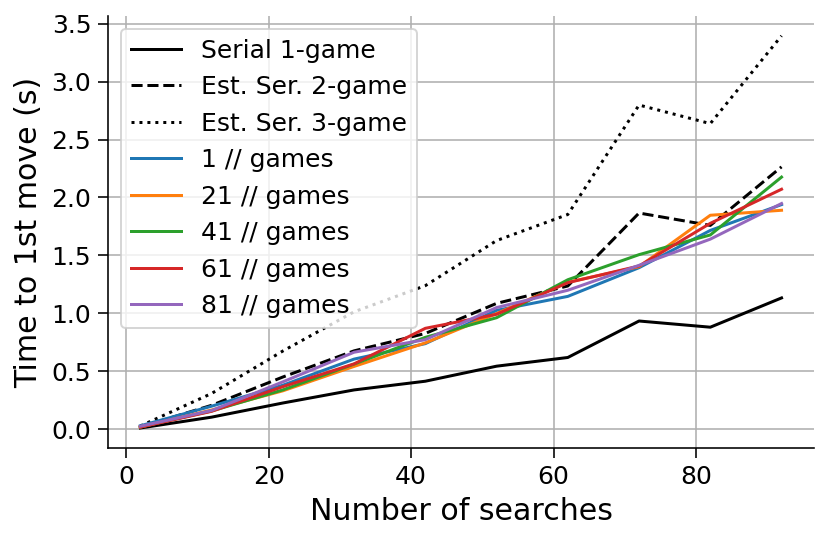

In [55]:
#@markdown Plot timings with batch size and search depth (run to plot)
n_games = np.arange(5)*20+1 # Need >= 1 game
n_search = np.arange(10)*10+2 # Need >= 2 searches
gg, ss = np.meshgrid(n_games, n_search)
par_times = np.zeros(gg.shape)
py_times = np.zeros(n_search.shape)
pbar = tqdm(desc='#search', total=n_search.sum())
for i, ns in enumerate(n_search):
    # Parallel games
    for j, ng in enumerate(n_games):
        game = OthelloGame(n_games=ng, n=8)
        tree = ParallelMCTSTree(policy_value_fun=random_policy_value_fun, n_games=ng, n=8, num_search=ns)
        tstart = time.time()
        tree.run_searches(game)
        par_times[i,j] = time.time() - tstart
    
    # Compare to pure python version
    game = OthelloGame(n_games=1, n=8)
    tree = MCTSTree(policy_value_fun=random_policy_value_fun, n_games=1, n=8, num_search=ns)
    tstart = time.time()
    tree.run_searches(game)
    py_times[i] = time.time() - tstart

    pbar.update(ns)
pbar.close()

plt.figure(figsize=(6,4))
plt.plot(n_search, py_times, 'k')
plt.plot(n_search, 2*py_times, '--k')
plt.plot(n_search, 3*py_times, ':k')
plt.plot(ss, par_times)
plt.legend(["Serial 1-game", "Est. Ser. 2-game", "Est. Ser. 3-game"] + [f'{ng} // games' for ng in n_games])
plt.xlabel('Number of searches')
plt.ylabel('Time to 1st move (s)')
plt.grid()
plt.show()

Describe why it is easy to parallelize over games but hard to parallelize over the searches within the MCTS tree rollout (i.e. the simulations in which actions are selected by the UCB).

In [56]:
why_tree_search_parallelization_hard = 'Multiple games can be played simultaneously, but for a given game rollout involves serially making moves.' #@param {type:"string"}

---
# Section 6: Using MCTS to train a policy and value network


Video available at https://youtube.com/watch?v=xpYaV7UBsnI


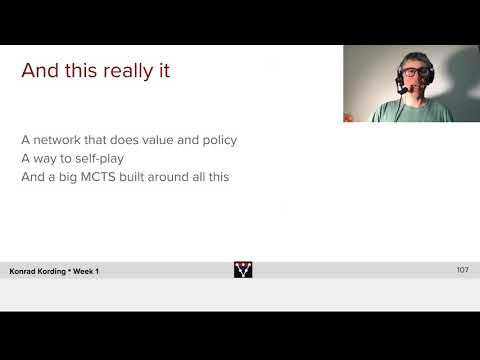

In [57]:
#@title Video: AlphaZero - Putting it All Together
param_list = ['why_tree_search_parallelization_hard']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

try: t6; 
except NameError: t6 = time.time()

video = YouTubeVideo(id="xpYaV7UBsnI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Now that we have a working parallel MCTS environment, we can finally train a policy. Remember, the "trick" of AlphaZero is to use the _visit counts_ returned by MCTS as a training target for the NN, while at the same time using the NN to guide the tree-search.

First, let's define a network that outputs a policy. In fact, let's define a two-headed network that will output both a policy and a value estimate. This is what AlphaZero does, too.

In [60]:
class PolicyValueNet(nn.Module):
    """This is a single neural network with two outputs: one "policy" output and
    one "value" output. It has two "heads" that share the same "body".
    """
    def __init__(self, num_channels=64, n=8, dropout=0.3):
        super(PolicyValueNet, self).__init__()
        
        # game params
        self.n = n
        self.dropout = dropout
        self.action_size = self.n*self.n
        self.num_channels = num_channels

        # Shared body: two conv layers followed by 2 fully connected layers
        self.conv1 = nn.Conv2d(1, num_channels, 3)
        self.conv2 = nn.Conv2d(num_channels, num_channels*2, 3)
        self.fc1 = nn.Linear(num_channels*2*(self.n-4)*(self.n-4), num_channels*2)
        self.fc2 = nn.Linear(num_channels*2, num_channels)

        # Value head: one more linear layer after fc2
        self.val_fc = nn.Linear(num_channels, 1)

        # Policy head: linear from fc2 to action_size
        self.pol_fc = nn.Linear(num_channels, self.action_size)

    def forward(self, s):
        # Body
        s = s.view(-1, 1, self.n, self.n)
        s = F.dropout2d(F.relu(self.conv1(s)), p=self.dropout, training=self.training)
        s = F.dropout2d(F.relu(self.conv2(s)), p=self.dropout, training=self.training)
        s = s.view(-1, self.num_channels*2*(self.n-4)*(self.n-4))
        s = F.dropout(F.relu(self.fc1(s)), p=self.dropout, training=self.training)
        s = F.dropout(F.relu(self.fc2(s)), p=self.dropout, training=self.training)
        
        # Value head
        v = torch.tanh(self.val_fc(s))
        
        # Policy head
        p = F.log_softmax(self.pol_fc(s), dim=1)

        return p, v

## Section 6.1: Preparing training examples

Now, our strategy is to observe self-play games of an MCTS agent and train on the following data:
 - For the policy, we need to pair the boards (the input) with the MCTS visit counts when that board was observed (the target)
 - For the value, we need to pair all boards seen in a game (input) with the eventual outcome (target)

Our strategy is to give `ai_vs_ai` a callback that makes it return the visit counts on every move (inside `ai_vs_ai`, the callback is done after the `MCTSAgent` has decided on their move, but before `game.step`).

In [61]:
def mcts_visits_callback(game:OthelloGame, agents:List[MCTSAgent]):
    """A callback to store visit counts in the MCTS agent's tree.

    Assuming both agents[0] and agents[1] are instances of MCTSAgent.
    """
    player_agent = agents[game.current_player-1]
    return player_agent.tree.count_child_visits(game).clone()

When we call `ai_vs_ai` with this callback it will return the key variables we need: `outcomes`, `raw_states`, and `raw_mcts_counts`. Just like last time, `outcomes` is a size `[n_games,2]` tensor that contains end-of-game values for player 1 in the 0th column and for player 2 in the 1st column.
```
outcomes, raw_states, raw_mcts_counts = ai_vs_ai(agent, callback=mcts_visits_callback)
```
And, just like last time, we will further process these raw states. That's what this next helper function `prepare_alpha_zero_examples` does. Don't worry too much about the implementation, but know that it:
1. Concatenates a list of board Tensors into one big Tensor
2. Gets the outcomes (1 per game) into the proper shape to act as targets for the value net (1 per board) 
3. Flips the sign of all boards and values that were from player 2's perspective to "pretend" like they are examples from player 1's perspective
4. Normalizes visit counts so they act as probabilities
5. Deals with passed moves
6. Adds board symmetries (rotations, reflections, etc.) for data augmentation



In [62]:
#@markdown RUN ME: Define `prepare_alpha_zero_examples` and `MCTSagent_from_net` helpers

def prepare_alpha_zero_examples(raw_states:List[torch.Tensor], 
                                raw_counts:List[torch.Tensor], 
                                player1_values:torch.Tensor):
    """Convert from ai_vs_ai output to training examples.

    This function performs canonical preprocessing (e.g. +1 is "current player"
    and -1 is "other player"), concatenates things, and adds in all symmetries.
    """
    n_moves = len(raw_states)
    n_games, n, _ = raw_states[0].size()
    # Concatenate and preprocess board states. Result is size [n_games*n_moves,n,n]
    # ordered like [game0turn0, game1turn0, ... gameNturn0, game0turn1, game1turn1, ... ]
    nn_states = boards2nn(raw_states)
    # Repeat values for every turn (player1_values begins as size [n_games])
    values = player1_values.flatten().float().repeat(n_moves)
    # Flip the sign of all boards that were player 2
    turn_number = torch.arange(n_moves)
    player = (turn_number % 2) + 1
    # 'repeat_interleave()' takes inputs [a b c] and repeats them like
    # [a a a ... b b b ... c c c ...]. Not to be confused with 'repeat()' which
    # outputs [a b c a b c a b c ...].
    player = player.repeat_interleave(n_games)
    nn_states[player == 2, ...] = -nn_states[player == 2, ...]
    values[player == 2, ...] = -values[player == 2, ...]
    # Concatenate and normalize all MCTS visit probabilities
    counts = torch.cat(raw_counts, dim=0).reshape(n_moves*n_games, n, n)
    total_visits = counts.sum(dim=2, keepdim=True).sum(dim=1, keepdim=True)
    probs = counts / total_visits
    # It may be the case that not all games ran for n_moves. These are indicated
    # by nan values in the board state (see ai_vs_ai). Also drop states in which
    # there were no legal moves, indicated by probs being nan (from 0/0)
    drop_states = torch.isnan(nn_states[:,0,0]) | torch.isnan(probs[:,0,0])
    train_states = nn_states[~drop_states, ...]
    train_probs  = probs[~drop_states, ...]
    train_values = values[~drop_states]
    # Add all symmetries (increases effective data 8-fold)
    train_states = torch.cat([sym(train_states) for sym in SYMMETRIES], dim=0)
    train_probs  = torch.cat([sym(train_probs) for sym in SYMMETRIES], dim=0)
    train_values = train_values.repeat(len(SYMMETRIES))
    
    return train_states, train_probs, train_values

def MCTSagent_from_net(policy_value_net: PolicyValueNet, n=8, 
                       games_per_iter=128, num_mcts_search=50):
    """A helper function that takes a PolicyValueNet and returns an MCTSAgent
    that uses that network."""

    def pol_val_fn(boards:torch.Tensor, whoami:torch.Tensor):
        """ This helper function creates prepares the boards to give to the network
        and puts the output in the correct shapes. For use inside the MCTS agent."""
        policy_value_net.eval()
        # Standard board to nn preprocessing: player 2 is now -1
        boards_nn = boards2nn(boards)
        # Always evaluate with +1 meaning "myself" and -1 meaning "other player"
        boards_nn[whoami == OthelloGame.PLAYER2, ...] = -boards_nn[whoami == OthelloGame.PLAYER2, ...]
        with torch.no_grad():   # saves on overhead
            log_policy_output, value = policy_value_net(boards_nn)
        policy = torch.exp(log_policy_output).view(-1, n, n)
        return policy, value.flatten()

    tree = ParallelMCTSTree(pol_val_fn, n_games=games_per_iter, n=n,
                            num_search=num_mcts_search)
    agent = MCTSAgent(tree, temperature=1.0)
    return agent

Let's think about point #3. Why not just feed in raw states to the neural nets? What would go wrong?

In [63]:
why_flip_perspective = 'Not flipping would mean that the network is training to improve outcomes for both players simultaneously, which would mean that overall it does not perform well. By improving game play for just one player, we generally improve game play for all players. ' #@param {type:"string"}

## Section 6.2: The AlphaZero training loop

Video available at https://youtube.com/watch?v=OArpVKM3B9I


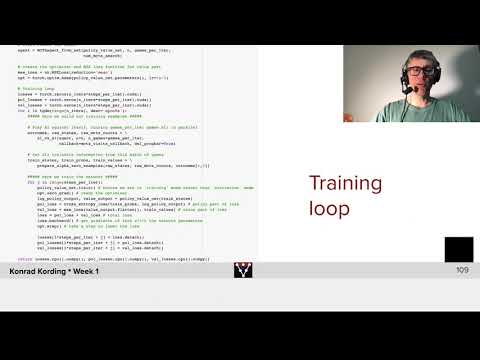

In [64]:
#@title Video: Training Loop
param_list = ['why_flip_perspective']
for param in param_list:
    if param not in locals():
        raise NameError("Please make sure to run the cell "
                        "after submitting your answer for <{}>!".format(param))

video = YouTubeVideo(id="OArpVKM3B9I", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Finally, let's build the loss function for policy. Remember this is the cross entropy:
$$CE(\vec\pi(s), p_\theta(s)) = -\vec\pi(s) \cdot \log \vec p_\theta(s)$$

The cross entropy is minimized when $\vec\pi(s)=p_\theta(s)$. Normally we might be able to use `torch.nn.CrossEntropyLoss`, but for technical reasons we have to roll our own here:

In [65]:
def cross_entropy_loss(target_p, log_q):
    """Computs the cross entropy. Assumes target_p is a normalized distribution
    and log_q is a log normalized distribution (e.g. output of log_softmax)"""
    b = target_p.size()[0]
    plogq = target_p.view(b, -1) * log_q.view(b, -1)
    cross_entropy = -plogq.sum(dim=1)
    return cross_entropy.mean()

Now, finally, we can define the training loop for AlphaZero!

In [66]:
def train_alpha_zero(policy_value_net, n_iters=20, steps_per_iter=50, n=8,
                     games_per_iter=128, num_mcts_search=50):
    """This master funtion creates the MCTSAgent from a policy/value net,
    then trains the networks via self-play"""
    
    # first create the agent
    agent = MCTSagent_from_net(policy_value_net, n, games_per_iter, 
                               num_mcts_search)
    
    # create the optimizer and MSE loss function for value part
    mse_loss = nn.MSELoss(reduction='mean')
    opt = torch.optim.Adam(policy_value_net.parameters(), lr=1e-3)

    # Training loop
    losses = torch.zeros(n_iters*steps_per_iter).cuda()
    pol_losses = torch.zeros(n_iters*steps_per_iter).cuda()
    val_losses = torch.zeros(n_iters*steps_per_iter).cuda()
    for i in tqdm(range(n_iters), desc='epochs'):
        ##### Here we build our training examples #####

        # Play AI against itself, running games_per_iter games all in parallel
        outcomes, raw_states, raw_mcts_counts = \
            ai_vs_ai(agent, n=n, n_games=games_per_iter,
                     callback=mcts_visits_callback, del_progbar=True)

        # Get all trainable information from this batch of games
        train_states, train_probs, train_values = \
            prepare_alpha_zero_examples(raw_states, raw_mcts_counts, outcomes[:,0])

        ##### Here we train the network #####
        for j in range(steps_per_iter):
            policy_value_net.train() # Ensure we are in 'training' mode rather than 'evaluation' mode
            opt.zero_grad() # ready the optimizer
            log_policy_output, value_output = policy_value_net(train_states)
            pol_loss = cross_entropy_loss(train_probs, log_policy_output) # policy part of loss
            val_loss = mse_loss(value_output.flatten(), train_values) # value part of loss
            loss = pol_loss + val_loss # total loss
            loss.backward() # get gradients of loss w/r/t the network parameters
            opt.step() # take a step to lower the loss

            losses[i*steps_per_iter + j] = loss.detach()
            pol_losses[i*steps_per_iter + j] = pol_loss.detach()
            val_losses[i*steps_per_iter + j] = val_loss.detach()

    return losses.cpu().numpy(), pol_losses.cpu().numpy(), val_losses.cpu().numpy()


## Section 6.3: Training the AlphaZero model

Video available at https://youtube.com/watch?v=9p-QUnUpNEI


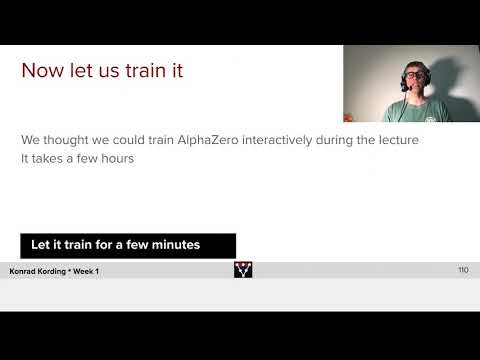

In [67]:
#@title Video: Training AlphaZero

video = YouTubeVideo(id="9p-QUnUpNEI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Run a few iterations of the following training code (about 1 minute) and take note of the total estimated training time. If you have time, you can let it run to completion to get your very own AlphaZero Othello model.


In [68]:
# Run this cell to train a model from scratch
n=8
pol_val_net = PolicyValueNet(n=n).cuda()
l, p_l, v_l = train_alpha_zero(pol_val_net, n_iters=100, steps_per_iter=50, n=n,
                               games_per_iter=128, num_mcts_search=20)

## Optional - save the trained model to your local machine. Note: you can use
## files.upload() in the future to upload your local files to colab
# from google.colab import files
# data = {"state_dict": pol_val_net.state_dict(),
#         "losses":l, "pol_losses": p_l, "val_losses": v_l}
# torch.save(data, f"my_policy_value_weights_{n}x{n}.pt")
# files.download(f"my_policy_value_weights_{n}x{n}.pt")

KeyboardInterrupt: ignored

Video available at https://youtube.com/watch?v=KzWGb0ay8mM


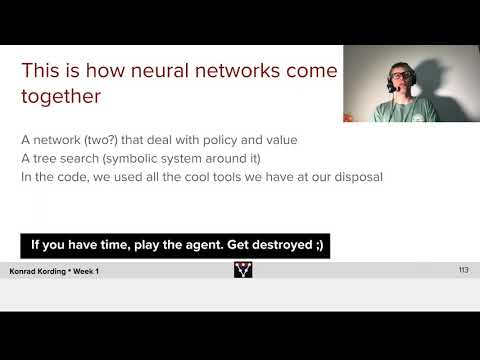

In [69]:
#@title Video: Loading Pretrained Results

video = YouTubeVideo(id="KzWGb0ay8mM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Here we have "pre-trained" a model for you which you will download in the cell following this one.

In [70]:
# Run this cell to download a pre-trained model. These models were trained with
# steps_per_iter=50, games_per_iter=128, and num_mcts_search=20. For 6x6 boards
# we trained for n_iters=100 and for 8x8 boards n_iters=200.
if n == 6:
    !if [ ! -f pretrained_policy_value_weights_6x6.pt ]; then wget https://osf.io/5hy6q/download -O pretrained_policy_value_weights_6x6.pt; fi
    data = torch.load("pretrained_policy_value_weights_6x6.pt")
elif n == 8:
    !if [ ! -f  pretrained_policy_value_weights_8x8.pt ]; then wget https://osf.io/8c6dx/download -O pretrained_policy_value_weights_8x8.pt; fi
    data = torch.load("pretrained_policy_value_weights_8x8.pt")

# Load pre-trained weights into the model
pol_val_net = PolicyValueNet(n=n).cuda()
pol_val_net.load_state_dict(data["state_dict"])
# Load losses for plotting
l, p_l, v_l = data["losses"], data["pol_losses"], data["val_losses"]

--2021-01-26 16:39:03--  https://osf.io/8c6dx/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/7v8qx/providers/osfstorage/5ffdc9c3e80d3703faa5a329?action=download&direct&version=2 [following]
--2021-01-26 16:39:03--  https://files.osf.io/v1/resources/7v8qx/providers/osfstorage/5ffdc9c3e80d3703faa5a329?action=download&direct&version=2
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2964447 (2.8M) [application/octet-stream]
Saving to: ‘pretrained_policy_value_weights_8x8.pt’

pretrained_policy_v 100%[===================>]   2.83M  --.-KB/s    in 0.06s   

2021-01-26 16:39:04 (46.9 MB/s) - ‘pretrained_policy_value_weights_8x8.pt’ saved [2964447/2964447]



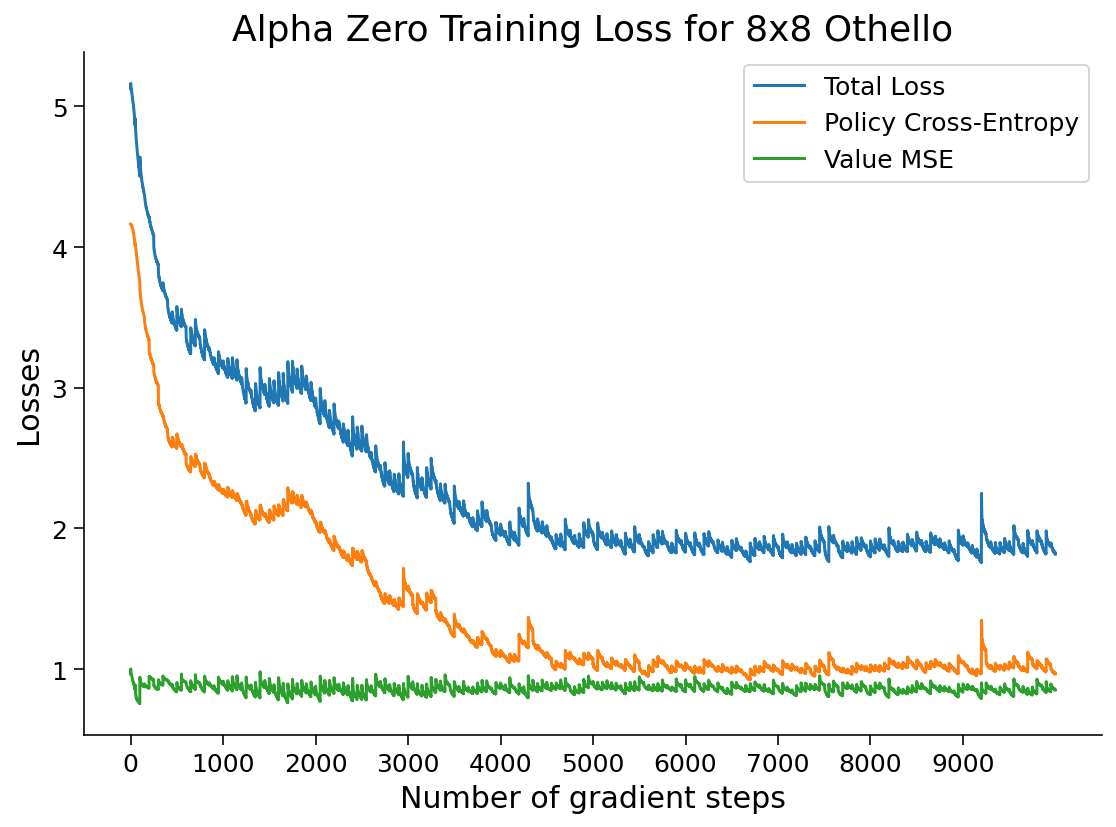

In [71]:
# Plot training loss from whichever model was used above
plt.plot(l)
plt.plot(p_l)
plt.plot(v_l)
plt.legend(["Total Loss", "Policy Cross-Entropy", "Value MSE"])
plt.xlabel('Number of gradient steps')
plt.xticks(np.arange(0,len(l),len(l)//10))
plt.ylabel('Losses')
plt.title(f'Alpha Zero Training Loss for {n}x{n} Othello')
plt.show()


How might you evaluate if it worked? One possible idea is to see how good is the learned policy at predicting MCTS visit counts:


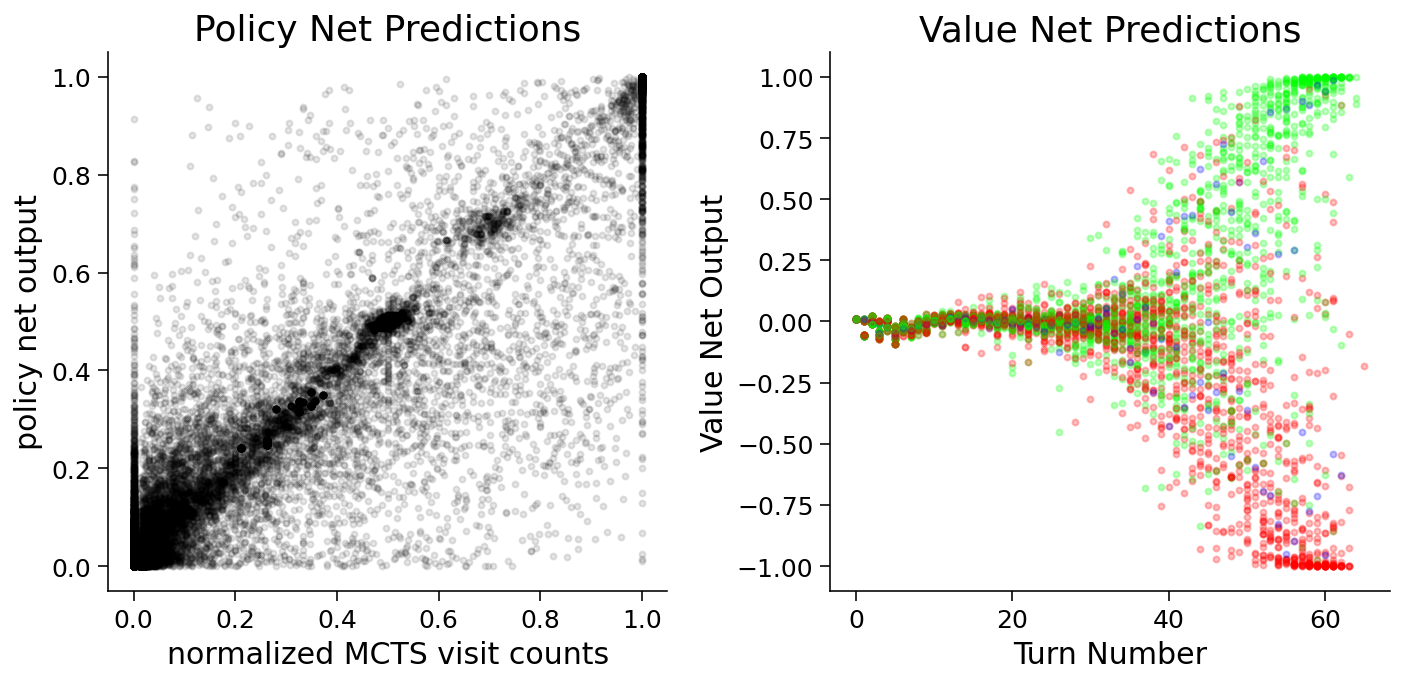

In [72]:
#@markdown (RUN ME) See alignment of policy to MCTS visit counts in a test game
pol_val_net.eval()
alpha_zero_agent = MCTSagent_from_net(pol_val_net, n, 100, 20)
alpha_zero_agent.temperature = 0.1
outcomes, raw_states, raw_mcts_counts = ai_vs_ai(alpha_zero_agent, n_games=100,
                                                 n=n, callback=mcts_visits_callback)
plt.figure(figsize=(10,5))
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
for t in range(len(raw_states)):
    sgn = +1 if t % 2 == 0 else -1
    player = 1 if t % 2 == 0 else 2
    pol_pred, val_pred = pol_val_net(sgn*boards2nn(raw_states[t]))
    counts_t = raw_mcts_counts[t].view(-1, n*n)
    targets_t = counts_t / counts_t.sum(dim=1, keepdim=True)
    valid = ~torch.any(torch.isnan(raw_states[t][:,0,0]))
    ax1.scatter(targets_t[valid,...].cpu().T, 
                pol_pred[valid,...].detach().exp().view(-1, n*n).cpu().T, 
                marker='.', c = 'k', alpha=.1)
    for g in range(len(raw_states)):
        if not torch.isnan(raw_states[t][g,0,0]):
            ax2.plot(t, val_pred[g].item(), marker='.', 
                      color=outcome2color(outcomes[g,player-1], 0.25))
  
ax1.set_xlabel('normalized MCTS visit counts')
ax1.set_ylabel('policy net output')
ax1.set_title('Policy Net Predictions')
ax2.set_xlabel('Turn Number')
ax2.set_ylabel('Value Net Output')
ax2.set_title('Value Net Predictions')
plt.show()

### (If time) play a game against your trained agent

In [ ]:
alpha_zero_agent = MCTSagent_from_net(pol_val_net, n=8, games_per_iter=1,
                                      num_mcts_search=50)
alpha_zero_agent.temperature = 0.1
interface = InteractiveOthelloGame(player1='human',
                                   player2=alpha_zero_agent, n=n)
interface.next_turn()

---
# Wrap-up: AlphaZero and society



Video available at https://youtube.com/watch?v=tP_80oRvufc


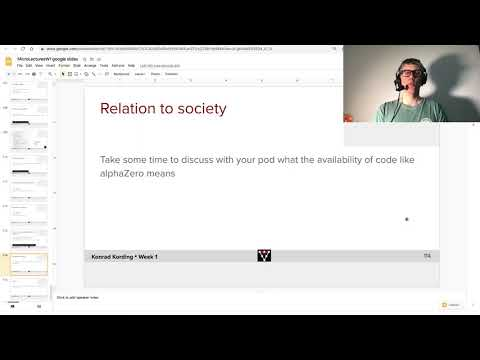

In [73]:
#@title Video: Society and Wrap Up

video = YouTubeVideo(id="tP_80oRvufc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Submit responses

In [74]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
from IPython.display import IFrame

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()
try: t7;
except NameError: t7 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: policy_strategy;
except NameError: policy_strategy = ""
try: how_to_train_policy;
except NameError: how_to_train_policy = ""
try: final_boards;
except NameError: final_boards = 0
try: average_valid_moves;
except NameError: average_valid_moves = 0
try: sum_to_4;
except NameError: sum_to_4 = ""
try: sign_of_q;
except NameError: sign_of_q = ""
try: visit_counts_meaning;
except NameError: visit_counts_meaning = ""
try: effect_of_cpuct;
except NameError: effect_of_cpuct = ""
try: action_selection_strategy;
except NameError: action_selection_strategy = ""
try: search_scaling;
except NameError: search_scaling = ""
try: train_time_bound;
except NameError: train_time_bound = ""
try: adjusted_train_time_bound;
except NameError: adjusted_train_time_bound = ""
try: why_tree_search_parallelization_hard;
except NameError: why_tree_search_parallelization_hard = ""
try: why_flip_perspective;
except NameError: why_flip_perspective = ""

times = [(t-t0) for t in [t1,t2,t3,t4,t5,t6,t7]]

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "policy_strategy": policy_strategy,
          "how_to_train_policy": how_to_train_policy,
          "final_boards": final_boards,
          "average_valid_moves": average_valid_moves,
          "sum_to_4": sum_to_4,
          "sign_of_q": sign_of_q,
          "visit_counts_meaning": visit_counts_meaning,
          "effect_of_cpuct": effect_of_cpuct,
          "action_selection_strategy": action_selection_strategy,
          "search_scaling": search_scaling,
          "train_time_bound": train_time_bound,
          "adjusted_train_time_bound": adjusted_train_time_bound,
          "why_tree_search_parallelization_hard": why_tree_search_parallelization_hard,
          "why_flip_perspective": why_flip_perspective,
          "cumulative_times": times}
src = "https://airtable.com/embed/shrxxokvcPAFaPvj0?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [ ]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))

## Homework: 

Complete the following assignment: https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W1_AlphaZero/student/W1_Homework.ipynb

This is due 1 week from today at the start of next week's Tutorial 2.